# Imports

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
try:
    from lifelines import KaplanMeierFitter
except:
    os.system('python -m pip install lifelines')
    from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
from tableone import TableOne
import math
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Loading the NCDB File

In [48]:
def load_data_her2(filename=None, savefile=None, loadfile=None, lower=True):
    """Load data from NCDB and print # excluded at each step

     Parameters
     ----------
     filename - name of csv NCDB PUF file
     savefile - Provide a string if you want to save the resultant dataframe as CSV (saves as 'saved_' + savefile)
     loadfile - Provide a string if you want to load a cleaned NCDB dataframe (from 'saved_' + loadfile)
     lower - True if the column headers need to be lowercase (NCDB 2017 switched from uppercase to lowercase)

     Returns
     -------
     dataframe with loaded NCDB dataset
     """
    if loadfile:
        return pd.read_csv(loadfile, dtype=str)
    
    #This next line specifies the columns from NCDB to load. These need to be in the same order as they are listed in NCDB
    fields = ['facility_type_cd', 'AGE', 'sex', 'RACE', 'spanish_hispanic_origin', 'insurance_status', 'cdcc_total_best', 'year_of_diagnosis', 'histology', 'behavior', 
              'GRADE', 'TUMOR_SIZE', 'REGIONAL_NODES_POSITIVE', 'TNM_CLIN_T', 'TNM_CLIN_N', 'TNM_CLIN_M', 'tnm_clin_stage_group', 'TNM_PATH_T', 'TNM_PATH_N', 'TNM_PATH_M', 
              'tnm_path_stage_group', 'analytic_stage_group', 'cs_mets_dx_bone', 'cs_mets_dx_brain', 'cs_mets_dx_liver', 'cs_mets_dx_lung', 'lymph_vascular_invasion', 'CS_SITESPECIFIC_FACTOR_8', 'CS_SITESPECIFIC_FACTOR_10', 'CS_SITESPECIFIC_FACTOR_12', 
              'CS_SITESPECIFIC_FACTOR_15', 'CS_SITESPECIFIC_FACTOR_16', 'CS_SITESPECIFIC_FACTOR_21', 'CS_SITESPECIFIC_FACTOR_22', 'CS_SITESPECIFIC_FACTOR_23', 'dx_defsurg_started_days', 'dx_chemo_started_days', 'RX_SUMM_CHEMO', 'dx_hormone_started_days', 'RX_SUMM_HORMONE', 
              'DX_LASTCONTACT_DEATH_MONTHS', 'PUF_VITAL_STATUS', 'tumor_size_summary_2016', 'mets_at_dx_bone', 'mets_at_dx_brain', 'mets_at_dx_liver', 'mets_at_dx_lung',  'ajcc_tnm_clin_n', 'ajcc_tnm_clin_stg_grp', 'ajcc_tnm_clin_t', 
              'ajcc_tnm_path_n', 'ajcc_tnm_path_stg_grp', 'ajcc_tnm_path_t', 'ajcc_tnm_post_path_n', 'ajcc_tnm_post_path_t', 'er_percent_pos_or_rng', 'er_summary',  'grade_clin', 'grade_path',  'her2_ich_summary', 
              'her2_ish_dual_num', 'her2_ish_dual_ratio', 'her2_ish_single_num', 'her2_overall_summ', 'ki67', 'oncotype_risk_invas', 'oncotype_score_inv', 'pr_percent_pos_or_rng', 'pr_summary']
    #Since the column names are confusing, we provide a list of shorter names to be used
    fieldname = ['facility', 'age', 'sex', 'race', 'hispanic', 'insurance', 'cdcc', 'year', 'histology', 'behavior', 
                 'grade', 'tumor_size', 'regional_nodes_positive', 'tnm_clin_t', 'tnm_clin_n', 'tnm_clin_m', 'tnm_clin_stage_group', 'tnm_path_t', 'tnm_path_n', 'tnm_path_m', 
                 'tnm_path_stage_group', 'stage', 'mets_bone', 'mets_brain', 'mets_liver', 'mets_lung', 'lvi', 'her2', 'her2ratio', 'her2copies', 
                 'her2sum', 'receptors', 'neoadj_response', 'recurrence_assay', 'recurrence_score', 'surg_days', 'chemo_days', 'rx_summ_chemo', 'hormone_days', 'rx_summ_hormone', 
                 'last_contact', 'alive',  'tumor_size_summary_2016', 'mets_at_dx_bone', 'mets_at_dx_brain', 'mets_at_dx_liver', 'mets_at_dx_lung', 'ajcc_tnm_clin_n', 'ajcc_tnm_clin_stg_grp', 'ajcc_tnm_clin_t', 
                 'ajcc_tnm_path_n', 'ajcc_tnm_path_stg_grp', 'ajcc_tnm_path_t', 'ajcc_tnm_post_path_n', 'ajcc_tnm_post_path_t', 'er_percent', 'er_summary', 'grade_clin', 'grade_path', 'her2_ich_summary', 
                 'her2_ish_dual_num', 'her2_ish_dual_ratio', 'her2_ish_single_num', 'her2_overall_summ',  'ki67', 'oncotype_risk_invas', 'oncotype_score_inv', 'pr_percent', 'pr_summary']

    #This converts the words in the 'fields' variable to lowercase
    if lower:
        fields = [f.lower() for f in fields]
    
    #This actually reads the CSV file
    df = pd.read_csv(filename, usecols=fields, dtype=str)

    
    #We set the column names within the CSV file to the simpler names
    df.columns = fieldname
    
    


    
    print("Total Patients in NCDB: " + str(len(df.index)))
    df['year'] = pd.to_numeric(df['year'], errors='coerce')
    df = df[df.year >= 2010]
    print("Excluding diagnoses before 2010: " + str(len(df.index)))

    df['age'] = pd.to_numeric(df['age'], errors='coerce')
    df.loc[df.age > 90, 'age'] = np.nan
    df['sex'] = pd.to_numeric(df['sex'], errors='coerce')
    df.loc[~df.sex.isin([1,2]), 'sex'] = np.nan
    
    df['race'] = pd.to_numeric(df['race'], errors='coerce')
    df['hispanic'] = pd.to_numeric(df['hispanic'], errors='coerce')
  
    df['race_parse'] = 0 #non-hispanic white
    df.loc[((df.race == 2) & (df.hispanic == 0)), 'race_parse'] = 1 #non-hispanic black
    df.loc[(df.hispanic > 0) & (df.hispanic < 9), 'race_parse'] = 2  # hispanic
    df.loc[((df.race == 98) & (df.hispanic == 0)), 'race_parse'] = 3 #other
    df.loc[((df.race == 3) & (df.hispanic == 0)), 'race_parse'] = 4 #Native american
    df.loc[((~df.race.isin([0,1,2,3,98,99])) & (df.hispanic == 0)), 'race_parse'] = 5 #asian / pacific islander
    df.loc[(~df.race.isin([0,1,2,3,98,99, np.nan])) & (df.hispanic == 0), 'race_parse'] = 5 #asian / pacific islander
    df.loc[df.race == 99, 'race_parse'] = np.nan #unknown race (we will ignore unknown ethnicity)
    
    df['histology'] = pd.to_numeric(df['histology'], errors='coerce')  
    df.loc[df.histology.isin([8500, 8501, 8502, 8503, 8504, 8505, 8506, 8507, 8508, 8523, 8230]), 'histology'] = 0 #ductal
    df.loc[df.histology.isin([8520, 8521, 8524, 8525]), 'histology'] = 1 #lobular
    df.loc[df.histology.isin([8522]), 'histology'] = 2 # mixed
    df.loc[df.histology.isin([8480, 8481]), 'histology'] = 3 # mucinous
    df.loc[df.histology.isin([8503, 8504, 8260, 8050, 8051, 8052]), 'histology'] = 4 # papillary
    df.loc[df.histology.isin([8211, 8210]), 'histology'] = 5 # tubular
    df.loc[df.histology.isin([8530]), 'histology'] = 6 # inflammatory
    df.loc[df.histology.isin([8510, 8512, 8513, 8514]), 'histology'] = 7 # medullary
    df.loc[df.histology.isin([8570, 8571, 8572, 8573, 8574, 8575, 8576]), 'histology'] = 8 # metaplsatic
    df.loc[df.histology.isin([8540, 8541, 8542, 8543]), 'histology'] = 9 # paget
    df.loc[(df.histology >= 8800) & (df.histology <= 9581), 'histology'] = 10 # sarcoma, etc    
    df.loc[~df.histology.isin([0,1,2,3,4,5,6,7,8,9,10,np.nan]), 'histology'] = 11 #other

    df = df[df.behavior.astype(float) == 3]
    print("Excluding non-invasive cases: " + str(len(df.index)))
    
    df['grade'] = pd.to_numeric(df['grade'], errors='coerce')  
    df.loc[df.grade == 4] = 3
    df.loc[~df.grade.astype(float).isin([1,2,3]), 'grade'] = np.nan
    
        
    #fix for later year of diagnosis:
    df.loc[(df.year.astype(float) >= 2018) & (df.grade_clin.isin(['H','3','C','D'])), 'grade'] = 3
    df.loc[(df.year.astype(float) >= 2018) & (df.grade_clin.isin(['M','2','B'])), 'grade'] = 2
    df.loc[(df.year.astype(float) >= 2018) & (df.grade_clin.isin(['L','1','A'])), 'grade'] = 1
    df.loc[(df.year.astype(float) >= 2018) & (df.grade_path.isin(['H','3','C','D'])), 'grade'] = 3
    df.loc[(df.year.astype(float) >= 2018) & (df.grade_path.isin(['M','2','B'])), 'grade'] = 2
    df.loc[(df.year.astype(float) >= 2018) & (df.grade_path.isin(['L','1','A'])), 'grade'] = 1
    
    #Tumor size likely obsolete
    df.loc[df.year.astype(float) >= 2018, 'tumor_size'] = df['tumor_size_summary_2016']
    df['tumor_size'] = pd.to_numeric(df['tumor_size'], errors='coerce')  
    df.loc[df.tumor_size.astype(float) == 990, 'tumor_size'] = 1
    df.loc[df.tumor_size.astype(float) == 991, 'tumor_size'] = 5 # < 1 cm
    df.loc[df.tumor_size.astype(float) == 992, 'tumor_size'] = 15 # 1-2 cm
    df.loc[df.tumor_size.astype(float) == 993, 'tumor_size'] = 25 # 2-3 cm
    df.loc[df.tumor_size.astype(float) == 994, 'tumor_size'] = 35 # 3-4 cm
    df.loc[df.tumor_size.astype(float) == 995, 'tumor_size'] = 45 # 4-5 cm
    df.loc[df.tumor_size.astype(float) > 995, 'tumor_size'] = np.nan
    
    
    #probably need to just use TNM stage
    df['regional_nodes_positive'] = pd.to_numeric(df['regional_nodes_positive'], errors='coerce')  
    df.loc[df.regional_nodes_positive.astype(float).isin([98,99]), 'regional_nodes_positive'] = np.nan
    
    df['pcr'] = 0
    df.loc[((df.tnm_path_n.str.contains("p0")) | df.neoadj_response.astype(float).isin([10]) | (df.tnm_path_n.str.contains("pI"))) & ((df.tnm_path_t.str.contains("p0")) | (df.tnm_path_t.str.contains("pIS"))), 'pcr'] = 1
    df.loc[((df.neoadj_response.astype(float) > 30) | (df.neoadj_response.astype(float) == 25)) & (df.tnm_path_n.str.contains("88") | df.tnm_path_n.str.contains("pX") | df.tnm_path_t.str.contains("88") | df.tnm_path_t.str.contains("pX") | (df.tnm_path_t == "") | (df.tnm_path_n == "")), 'pcr'] = np.nan
    df.loc[(df.year.astype(float) >= 2018), 'pcr'] = 0
    df.loc[(df.year.astype(float) >= 2018) & (df.ajcc_tnm_post_path_n.str.contains('N0') & (df.ajcc_tnm_post_path_t.str.contains('T0') | df.ajcc_tnm_post_path_t.str.contains('Tis'))), 'pcr'] = 1
    df.loc[(df.year.astype(float) >= 2018) & (df.ajcc_tnm_post_path_n.str.contains('NX') | df.ajcc_tnm_post_path_t.str.contains('TX') | (df.ajcc_tnm_post_path_n == '') | (df.ajcc_tnm_post_path_t == '')), 'pcr'] = 1


    df.loc[(df.year.astype(float) >= 2018), 'mets_bone'] = df['mets_at_dx_bone']
    df.loc[(df.year.astype(float) >= 2018), 'mets_brain'] = df['mets_at_dx_brain']
    df.loc[(df.year.astype(float) >= 2018), 'mets_liver'] = df['mets_at_dx_liver']
    df.loc[(df.year.astype(float) >= 2018), 'mets_lung'] = df['mets_at_dx_lung']
    
    df['mets_bone'] = pd.to_numeric(df['mets_bone'], errors='coerce')  
    df['mets_brain'] = pd.to_numeric(df['mets_brain'], errors='coerce')  
    df['mets_liver'] = pd.to_numeric(df['mets_liver'], errors='coerce')  
    df['mets_lung'] = pd.to_numeric(df['mets_lung'], errors='coerce')  
    
    df.loc[(df.mets_bone.astype(float) > 2), 'mets_bone'] = np.nan
    df.loc[(df.mets_brain.astype(float) > 2), 'mets_brain'] = np.nan
    df.loc[(df.mets_liver.astype(float) > 2), 'mets_liver'] = np.nan
    df.loc[(df.mets_lung.astype(float) > 2), 'mets_lung'] = np.nan

    # Now the most important part - we can select which patients we want to look at!
    # First, lets only use patients who are characterized as HER2 positive by their testing:
    # The CS_SITESPECIFIC_FACTOR_15 column corresponds to the summary of her2 testing, which I renamed her2sum
    # If you review https://web2.facs.org/cstage0205/breast/Breastschema.html - you can see that HER2 positive is coded as 20
    
    # The following code selects all rows from our 'dataframe' where the her2sum variable is in the provided list of [20]
    # We say .astype(float) because some of the data from NCDB is loaded as sequences of characters or 'strings' by default
    # A float is a floating point number, so it allows us to comare the values to other numbers
    # Notice that the 20 in brackets [20] doesn't have quotations around it, this indicates it is a number and not a string
    # You can access columns in dataframes in two ways: df['column'] or df.column
    df = df[df.her2sum.astype(float).isin([20]) | df.her2_overall_summ.astype(float).isin([0])]
    print("Excluding cases classified as HER2+: " + str(len(df.index)))
    
    
    df['receptors'] = pd.to_numeric(df['receptors'], errors='coerce')
    df.loc[df.receptors.astype(float) > 111, 'receptors'] = np.nan   
    df.pr_summary = pd.to_numeric(df.pr_summary, errors = 'coerce')
    df.er_summary = pd.to_numeric(df.er_summary, errors = 'coerce')
    df.loc[(df.pr_summary.isin([0, 1])) & (df.er_summary.isin([0, 1])) & (df.her2_overall_summ.astype(float).isin([0,1])), 'receptors'] = df.er_summary.astype(float) * 100 + df.pr_summary.astype(float) * 10 + df.her2_overall_summ.astype(float)
    df = df[df.receptors.astype(float).isin([0,10,100,110,np.nan])]

    df['er_num'] = pd.to_numeric(df['er_percent'], errors='coerce')
    df.loc[df.er_percent == 'R10', 'er_num'] = 5
    df.loc[df.er_percent == 'R20', 'er_num'] = 15
    df.loc[df.er_percent == 'R30', 'er_num'] = 25
    df.loc[df.er_percent == 'R40', 'er_num'] = 35
    df.loc[df.er_percent == 'R50', 'er_num'] = 45
    df.loc[df.er_percent == 'R60', 'er_num'] = 55
    df.loc[df.er_percent == 'R70', 'er_num'] = 65
    df.loc[df.er_percent == 'R80', 'er_num'] = 75
    df.loc[df.er_percent == 'R90', 'er_num'] = 85
    df.loc[df.er_percent == 'R99', 'er_num'] = 95

    df['pr_num'] = pd.to_numeric(df['pr_percent'], errors='coerce')
    df.loc[df.pr_percent == 'R10', 'pr_num'] = 5
    df.loc[df.pr_percent == 'R20', 'pr_num'] = 15
    df.loc[df.pr_percent == 'R30', 'pr_num'] = 25
    df.loc[df.pr_percent == 'R40', 'pr_num'] = 35
    df.loc[df.pr_percent == 'R50', 'pr_num'] = 45
    df.loc[df.pr_percent == 'R60', 'pr_num'] = 55
    df.loc[df.pr_percent == 'R70', 'pr_num'] = 65
    df.loc[df.pr_percent == 'R80', 'pr_num'] = 75
    df.loc[df.pr_percent == 'R90', 'pr_num'] = 85
    df.loc[df.pr_percent == 'R99', 'pr_num'] = 95
    
    df['ki67_num'] = pd.to_numeric(df['ki67'], errors='coerce')

        

    
    # Next, we want HER2 IHC to be 0+ to 2+ (3+ is positive). Technically this should be 0, 10, or 20, corresponding to
    # 0+, 1+, and 2+, if we again review the site specific factors (this time, site specific factor 8).
    # However, 1 and 2 used to signify 1+ and 2+, so I included these to catch a few patients who were miscoded
    
    df.loc[df.her2_ich_summary.astype(float).isin([0]), 'her2'] = 0
    df.loc[df.her2_ich_summary.astype(float).isin([1]), 'her2'] = 1
    df.loc[df.her2_ich_summary.astype(float).isin([2]), 'her2'] = 2
    df.loc[df.her2.astype(float) == 10, 'her2'] = 1
    df.loc[df.her2.astype(float) == 20, 'her2'] = 2
    df = df[(df.her2.astype(float).isin([0, 1, 2]))]

    print("Excluding cases where HER2 IHC isn't 0-2: " + str(len(df.index)))

    df['her2ratio'] = pd.to_numeric(df['her2ratio'], errors='coerce') 
    df.loc[df.her2ratio.astype(float).isin([981,982,983,984,985,986,987]), 'her2ratio'] = 980
    df.loc[df.her2ratio.astype(float).isin([991]), 'her2ratio'] = 100
    df.loc[df.her2ratio.astype(float).isin([988, 989, 990, 992, 993, 994, 995, 996, 997, 998, 999]), 'her2ratio'] = np.nan
    df.loc[df.her2ratio.astype(float) < 100, 'her2ratio'] = np.nan
    df['her2ratio'] = df['her2ratio'].astype(float)/100
    df['her2_ish_dual_ratio'] = pd.to_numeric(df['her2_ish_dual_ratio'], errors='coerce')
    df.loc[~df.her2_ish_dual_ratio.isna(), 'her2ratio'] = df['her2_ish_dual_ratio']
    
    df['her2copies'] = pd.to_numeric(df['her2copies'], errors='coerce')
    df.loc[df.her2copies.astype(float).isin([981,982,983,984,985,986,987]), 'her2copies'] = 980
    df.loc[df.her2copies.astype(float).isin([991]), 'her2copies'] = 100
    df.loc[df.her2copies.astype(float).isin([988, 989, 990, 992, 993, 994, 995, 996, 997, 998, 999]), 'her2copies'] = np.nan
    df.loc[df.her2copies.astype(float) < 100, 'her2copies'] = np.nan
    df['her2copies'] = df['her2copies'].astype(float)/100
    df['her2_ish_dual_num'] = pd.to_numeric(df['her2_ish_dual_num'], errors='coerce')
    df.loc[~df.her2_ish_dual_num.isna(), 'her2copies'] = df['her2_ish_dual_num']
    df['her2_ish_single_num'] = pd.to_numeric(df['her2_ish_single_num'], errors='coerce')
    df.loc[~df.her2_ish_single_num.isna(), 'her2copies'] = df['her2_ish_single_num']

    df = df[(~df.her2ratio.isna()) | (~df.her2copies.isna()) | (df.her2.astype(float) < 2)]
    print("Excluding cases where HER2 IHC is 2 and FISH is not performed: " + str(len(df.index)))
        
    df = df[(df.her2.astype(float) < 2) | (df.her2copies.astype(float) < 6) | (~df.her2ratio.isna())]
    print("Excluding cases where HER2 IHC is 2 and FISH CN >= 6: " + str(len(df.index)))

    df = df[(df.her2.astype(float) < 2) | (df.her2copies.astype(float) < 4) | (df.her2ratio.astype(float) < 2)]
    print("Excluding cases where HER2 IHC is 2 and FISH CN >= 4 and ratio >= 2: " + str(len(df.index)))

    df['odx'] = np.nan
    df.loc[(df.recurrence_assay.astype(float) == 10) & (df.recurrence_score.astype(float) < 101), 'odx'] = df.recurrence_score.astype(float)
    df['oncotype_risk_invas'] = pd.to_numeric(df.oncotype_risk_invas, errors = 'coerce')
    df['oncotype_score_inv'] = pd.to_numeric(df.oncotype_score_inv, errors = 'coerce')
    df.loc[(df.oncotype_risk_invas.astype(float).isin([0,1])), 'odx'] = df['oncotype_score_inv'].astype(float)
                                                           
    df['chemo'] = np.nan
    df.loc[df.rx_summ_chemo.astype(float).isin([1,2,3]), 'chemo'] = 1
    df.loc[df.rx_summ_chemo.astype(float).isin([0, 82, 85, 86, 87]), 'chemo'] = 0
                                                           
    df['hormone'] = np.nan
    df.loc[df.rx_summ_hormone.astype(float).isin([1]), 'hormone'] = 1
    df.loc[df.rx_summ_hormone.astype(float).isin([0, 82, 85, 86, 87]), 'hormone'] = 0

    df['surg_days'] = pd.to_numeric(df['surg_days'], errors='coerce')
    df['chemo_days'] = pd.to_numeric(df['chemo_days'], errors='coerce')
    df['hormone_days'] = pd.to_numeric(df['hormone_days'], errors='coerce')

    df['neoadj_chemo'] = np.nan
    df.loc[df['surg_days'] > df['chemo_days'] + 30, 'neoadj_chemo'] = 1
    df.loc[df['surg_days'] <= df['chemo_days'] + 30, 'neoadj_chemo'] = 0
    df.loc[df.neoadj_response.astype(float).isin([10,20,25,30]), 'neoadj_chemo'] = 1
    df.loc[df.neoadj_response.astype(float).isin([987, 998]), 'neoadj_chemo'] = 0
    df.loc[df.ajcc_tnm_post_path_t.str.contains('yp') | df.ajcc_tnm_post_path_n.str.contains('yp'), 'neoadj_chemo'] = 1
    df.loc[df.chemo == 0, 'neoadj_chemo'] = 0                                                         

    df['neoadj_endo'] = np.nan
    df.loc[df['surg_days'] > df['hormone_days'] + 30, 'neoadj_endo'] = 1
    df.loc[df['surg_days'] <= df['hormone_days'] + 30, 'neoadj_endo'] = 0
    df.loc[df.hormone == 0, 'neoadj_endo'] = 0

    df.loc[(df.neoadj_chemo == 1) & (df.neoadj_endo == 1), 'neoadj_endo'] = 0

    #df['stage'] = pd.to_numeric(df['stage'], errors='coerce')  
    #df.loc[df.stage.astype(float) > 4, 'stage'] = np.nan
    #df = df[df.stage > 0]


    

    
    df['clin_stage'] = np.nan
    df.loc[df.tnm_clin_stage_group.astype('string').str.contains('1'), 'clin_stage'] = 1
    df.loc[df.tnm_clin_stage_group.astype('string').str.contains('2'), 'clin_stage'] = 2
    df.loc[df.tnm_clin_stage_group.astype('string').str.contains('3'), 'clin_stage'] = 3
    df.loc[df.tnm_clin_stage_group.astype('string').str.contains('4'), 'clin_stage'] = 4
    df.loc[df.tnm_clin_stage_group.astype('string').str.contains('0'), 'clin_stage'] = 0

    df.loc[df.ajcc_tnm_clin_stg_grp.astype('string').str.contains('1'), 'clin_stage'] = 1
    df.loc[df.ajcc_tnm_clin_stg_grp.astype('string').str.contains('2'), 'clin_stage'] = 2
    df.loc[df.ajcc_tnm_clin_stg_grp.astype('string').str.contains('3'), 'clin_stage'] = 3
    df.loc[df.ajcc_tnm_clin_stg_grp.astype('string').str.contains('4'), 'clin_stage'] = 4
    df.loc[df.ajcc_tnm_clin_stg_grp.astype('string').str.contains('0'), 'clin_stage'] = 0
    
    df['path_stage'] = np.nan
    df.loc[df.tnm_path_stage_group.astype('string').str.contains('1'), 'path_stage'] = 1
    df.loc[df.tnm_path_stage_group.astype('string').str.contains('2'), 'path_stage'] = 2
    df.loc[df.tnm_path_stage_group.astype('string').str.contains('3'), 'path_stage'] = 3
    df.loc[df.tnm_path_stage_group.astype('string').str.contains('4'), 'path_stage'] = 4
    df.loc[df.tnm_path_stage_group.astype('string').str.contains('0'), 'path_stage'] = 0

    df.loc[df.ajcc_tnm_path_stg_grp.astype('string').str.contains('1'), 'path_stage'] = 1
    df.loc[df.ajcc_tnm_path_stg_grp.astype('string').str.contains('2'), 'path_stage'] = 2
    df.loc[df.ajcc_tnm_path_stg_grp.astype('string').str.contains('3'), 'path_stage'] = 3
    df.loc[df.ajcc_tnm_path_stg_grp.astype('string').str.contains('4'), 'path_stage'] = 4
    df.loc[df.ajcc_tnm_path_stg_grp.astype('string').str.contains('0'), 'path_stage'] = 0
    
    df['clin_t'] = np.nan
    df.loc[df.tnm_clin_t.astype('string').str.contains('0'), 'clin_t'] = 0
    df.loc[df.tnm_clin_t.astype('string').str.contains('1'), 'clin_t'] = 1
    df.loc[df.tnm_clin_t.astype('string').str.contains('2'), 'clin_t'] = 2
    df.loc[df.tnm_clin_t.astype('string').str.contains('3'), 'clin_t'] = 3
    df.loc[df.tnm_clin_t.astype('string').str.contains('4'), 'clin_t'] = 4
    df.loc[df.ajcc_tnm_clin_t.astype('string').str.contains('0'), 'clin_t'] = 0
    df.loc[df.ajcc_tnm_clin_t.astype('string').str.contains('1'), 'clin_t'] = 1
    df.loc[df.ajcc_tnm_clin_t.astype('string').str.contains('2'), 'clin_t'] = 2
    df.loc[df.ajcc_tnm_clin_t.astype('string').str.contains('3'), 'clin_t'] = 3
    df.loc[df.ajcc_tnm_clin_t.astype('string').str.contains('4'), 'clin_t'] = 4

    df['path_t'] = np.nan
    df.loc[df.tnm_path_t.astype('string').str.contains('0'), 'path_t'] = 0
    df.loc[df.tnm_path_t.astype('string').str.contains('1'), 'path_t'] = 1
    df.loc[df.tnm_path_t.astype('string').str.contains('2'), 'path_t'] = 2
    df.loc[df.tnm_path_t.astype('string').str.contains('3'), 'path_t'] = 3
    df.loc[df.tnm_path_t.astype('string').str.contains('4'), 'path_t'] = 4
    df.loc[df.ajcc_tnm_path_t.astype('string').str.contains('0'), 'path_t'] = 0
    df.loc[df.ajcc_tnm_path_t.astype('string').str.contains('1'), 'path_t'] = 1
    df.loc[df.ajcc_tnm_path_t.astype('string').str.contains('2'), 'path_t'] = 2
    df.loc[df.ajcc_tnm_path_t.astype('string').str.contains('3'), 'path_t'] = 3
    df.loc[df.ajcc_tnm_path_t.astype('string').str.contains('4'), 'path_t'] = 4

    df['clin_n'] = np.nan
    df.loc[df.tnm_clin_n.astype('string').str.contains('0'), 'clin_n'] = 0
    df.loc[df.tnm_clin_n.astype('string').str.contains('1'), 'clin_n'] = 1
    df.loc[df.tnm_clin_n.astype('string').str.contains('2'), 'clin_n'] = 2
    df.loc[df.tnm_clin_n.astype('string').str.contains('3'), 'clin_n'] = 3
    df.loc[df.ajcc_tnm_clin_n.astype('string').str.contains('0'), 'clin_n'] = 0
    df.loc[df.ajcc_tnm_clin_n.astype('string').str.contains('1'), 'clin_n'] = 1
    df.loc[df.ajcc_tnm_clin_n.astype('string').str.contains('2'), 'clin_n'] = 2
    df.loc[df.ajcc_tnm_clin_n.astype('string').str.contains('3'), 'clin_n'] = 3

    df['path_n'] = np.nan
    df.loc[df.tnm_path_n.astype('string').str.contains('0'), 'path_n'] = 0
    df.loc[df.tnm_path_n.astype('string').str.contains('1'), 'path_n'] = 1
    df.loc[df.tnm_path_n.astype('string').str.contains('2'), 'path_n'] = 2
    df.loc[df.tnm_path_n.astype('string').str.contains('3'), 'path_n'] = 3
    df.loc[df.ajcc_tnm_path_n.astype('string').str.contains('0'), 'path_n'] = 0
    df.loc[df.ajcc_tnm_path_n.astype('string').str.contains('1'), 'path_n'] = 1
    df.loc[df.ajcc_tnm_path_n.astype('string').str.contains('2'), 'path_n'] = 2
    df.loc[df.ajcc_tnm_path_n.astype('string').str.contains('3'), 'path_n'] = 3

    #df['stage'] = df[['stage', 'clin_stage', 'path_stage']].max(axis=1)
    
    #df['stage'] = df['path_stage']
    df.loc[df.neoadj_chemo == 1, 'stage'] = df['clin_stage']
    df.loc[df.stage.isna(), 'stage'] = df['path_stage']
    df.loc[df.stage.isna(), 'stage'] = df['clin_stage']
    
    df['t_stage'] = df['path_t']
    df.loc[df.neoadj_chemo == 1, 't_stage'] = df['clin_t']
    df['n_stage'] = df['path_n']
    df.loc[df.neoadj_chemo == 1, 'n_stage'] = df['clin_n']
    
    #Exclude stage 0 patients
    df.stage = pd.to_numeric(df.stage, errors='coerce')
    df = df[(df.stage > 0) & (df.stage <= 4)]
    print("Excluding Stage 0 cases: " + str(len(df.index)))

    
    df.loc[df.mets_bone == 1, 'stage'] = 4
    df.loc[df.mets_brain == 1, 'stage'] = 4
    df.loc[df.mets_liver == 1, 'stage'] = 4
    df.loc[df.mets_lung == 1, 'stage'] = 4

    df.loc[df.stage < 4, 'mets_bone'] = 0
    df.loc[df.stage < 4, 'mets_brain'] = 0
    df.loc[df.stage < 4, 'mets_liver'] = 0
    df.loc[df.stage < 4, 'mets_lung'] = 0
    
    df['alive'] = df['alive'].astype(float)
    df['alive'] = 1 - df['alive'] #To give death rate instead of survival
    
    # We can now save our more limited datafile if we wnat
    if savefile:
        df.to_csv(savefile, index=False)
    
    # This returns the dataframe as a result of the function, so it can be accessed for further processing
    return df

Let's demonstrate the use of our above NCDB accessing function. Replace the filename with your copy of NCDB.

This code will take some time to execute! Try not to rerun it

In [49]:
#This assigns the result of the above function to 'df'
df = load_data_her2(filename="NCDBPUF_Breast.0.2019.csv", savefile="NCDB_Subset.csv", lower=True)

df['her2'] = pd.to_numeric(df['her2'], errors='raise')
df['facility'] = pd.to_numeric(df['facility'], errors='raise')
df['cdcc'] = pd.to_numeric(df['cdcc'], errors='raise')
df['last_contact'] = pd.to_numeric(df['last_contact'], errors='raise')

Total Patients in NCDB: 3446070
Excluding diagnoses before 2010: 2350990
Excluding non-invasive cases: 1899814
Excluding cases classified as HER2+: 1521085
Excluding cases where HER2 IHC isn't 0-2: 1207440
Excluding cases where HER2 IHC is 2 and FISH is not performed: 1162763
Excluding cases where HER2 IHC is 2 and FISH CN >= 6: 1162527
Excluding cases where HER2 IHC is 2 and FISH CN >= 4 and ratio >= 2: 1158109
Excluding Stage 0 cases: 1136016


# Generating Baseline Demographics

In [50]:
def baselineCharacteristics(df, split12 = False):
    """Generate baseline characteristics table, prints results into console

        Parameters
        ----------
        df - dataframe to use
        """
    print("Median Follow-up: " + str(df['last_contact'].median()))
    columns = ['age', 'age_group', 'sex', 'race_parse', 'facility', 'cdcc', 'year', 'grade', 'histology', 'tumor_size', 'reg_node_cat', 't_stage', 'n_stage', 'stage', 'mets_bone', 
               'mets_brain', 'mets_liver', 'mets_lung', 'her2_group', 'her2ratio', 'her2copies', 'receptors', 'er_num', 'pr_num', 'ki67_num', 'recurrence_score_group', 'chemo', 'hormone', 'last_contact', 'alive']
    labels = {'age':'Age', 'age_group':'Age', 'sex':'Sex', 'race_parse':'Race / Ethnicity', 'cdcc':'Charlson/Dayo Score', 'facility':'Facility Type', 'year':'Diagnosis Year', 
              'grade':'Grade', 'histology':'Histologic Subtype', 'tumor_size':'Tumor Size (mm)', 'reg_node_cat':'Lymph Node Status', 't_stage':'T Stage', 'n_stage':'N Stage', 'stage':'Stage Group', 'mets_bone':'Bone Mets at Diagnosis', 'mets_brain':'Brain Mets at Diagnosis', 'mets_liver':'Liver Mets at Diagnosis', 'mets_lung':'Lung Mets at Diagnosis',
              'her2_group':'HER2 Group', 'her2ratio':'HER2/CEP17 Ratio', 'her2copies':'HER2 Copies', 'receptors':'Receptor Status', 'er_num':'ER (% Positive)', 'pr_num':'PR (% Positive)', 'ki67_num':'Ki67 (% Positive)',
              'recurrence_score_group':'OncotypeDx Score', 'chemo':'Chemotherapy', 'hormone':'Hormonal Therapy', 'last_contact':'Last Contact Months', 'alive':'Vital Status'}
    categorical = ['age_group', 'sex', 'race_parse', 'facility', 'cdcc', 'grade', 'histology', 'reg_node_cat', 't_stage', 'n_stage', 'stage', 'mets_bone', 'mets_brain', 'mets_liver', 'mets_lung', 'receptors', 'recurrence_score_group', 'chemo', 'hormone', 'alive']
    for c in ['sex', 'race_parse', 'facility', 'cdcc', 'histology', 'regional_nodes_positive', 'receptors', 'odx', 'chemo', 'hormone']:
        df[c] = pd.to_numeric(df[c], errors='coerce')
    df['age_group'] = np.nan
    df.loc[df.age < 40, 'age_group'] = '< 40'
    df.loc[df.age >= 40, 'age_group'] = '40 - 49'
    df.loc[df.age >= 50, 'age_group'] = '50 - 59'
    df.loc[df.age >= 60, 'age_group'] = '60 - 69'
    df.loc[df.age >= 70, 'age_group'] = '70 - 79'
    df.loc[df.age >= 80, 'age_group'] = '80+'
    
    df['sex'] = df.sex.map({1:'Male', 2:'Female'})
    df['race_parse'] = df.race_parse.map({0:'Non-Hispanic White', 1:'Non-Hispanic Black', 2:'Hispanic', 3:'Other', 4:'Native American', 5:'Asian'})
    df['facility'] = df.facility.map({1:'Community Cancer Program', 2:'Comprehensive Comunity Cancer Program', 3:'Academic / Research', 4:'Integrated Network Cancer Program'})
    df['cdcc'] = df.cdcc.map({0: '0', 1: '>= 1', 2: '>= 1', 3: '>= 1'})
    df['histology'] = df.histology.map({0: 'Ductal', 1: 'Lobular', 2: 'Ductal and Lobular', 
                                        3: 'Mucinous', 4: 'Papillary', 5: 'Tubular', 6: 'Inflammatory',
                                        7: 'Medullary', 8: 'Metaplastic', 9: 'Paget Disease', 10: 'Sarcoma',
                                        11: 'Others'})
    df['reg_node_cat'] = np.nan
    df.loc[df.regional_nodes_positive.isin([0]), 'reg_node_cat'] = '0 Positive'
    df.loc[df.regional_nodes_positive.isin([1]), 'reg_node_cat'] = '1 Node'
    df.loc[(df.regional_nodes_positive > 1) & (df.regional_nodes_positive <= 90), 'reg_node_cat'] = '2+ Nodes'
    df['her2_group'] = 'HER2 0'
    if not split12:
        df.loc[df.her2 > 0, 'her2_group'] = 'HER2 Low'
    else:
        df.loc[df.her2 == 1, 'her2_group'] = 'HER2 1+'
        df.loc[df.her2 == 2, 'her2_group'] = 'HER2 2+'
    df['receptors'] = df.receptors.map({0:'TNBC', 10:'ER-PR+', 100:'ER+PR-', 110:'ER+PR+'})
    df['alive'] = df.alive.map({0: 'Alive', 1: 'Deceased'})
    df['recurrence_score_group'] = np.nan
    df.loc[df.odx >= 0, 'recurrence_score_group'] = "Low (0 - 10)"
    df.loc[df.odx >= 11, 'recurrence_score_group'] = "Intermediate (11 - 25)"
    df.loc[df.odx >= 26, 'recurrence_score_group'] = "High (26+)"
    df['chemo'] = df.chemo.map({0: 'No Chemo', 1: 'Chemotherapy'})
    df['hormone'] = df.hormone.map({0: 'No Hormonal Therapy', 1: 'Hormonal Therapy'})

    mytable = TableOne(df, columns=columns, categorical=categorical, groupby='her2_group', pval=True, labels = labels)
    print(mytable.tabulate(tablefmt="github"))
    splitstr = ''
    if split12:
        splitstr = ' - split her2 1 vs 2'
    mytable.to_excel('table one' + splitstr + '.xlsx')
    mytable = TableOne(df, columns=columns, categorical=categorical, groupby='her2_group', pval=True, row_percent = True, labels = labels)
    print(mytable.tabulate(tablefmt="github"))
    mytable.to_excel('table one - percent row' + splitstr + '.xlsx')

baselineCharacteristics(df.copy(), split12 = False)
baselineCharacteristics(df.copy(), split12 = True)

Median Follow-up: 53.62
|                                |                                       | Missing   | Overall        | HER2 0        | HER2 Low      | P-Value   |
|--------------------------------|---------------------------------------|-----------|----------------|---------------|---------------|-----------|
| n                              |                                       |           | 1136016        | 392246        | 743770        |           |
| Age, mean (SD)                 |                                       | 0         | 62.4 (13.1)    | 62.1 (13.2)   | 62.5 (13.0)   | <0.001    |
| Age, n (%)                     | 40 - 49                               | 0         | 158040 (13.9)  | 55541 (14.2)  | 102499 (13.8) | <0.001    |
|                                | 50 - 59                               |           | 255811 (22.5)  | 88438 (22.5)  | 167373 (22.5) |           |
|                                | 60 - 69                               |           | 3

|                                |                                       | Missing   | Overall         | HER2 0        | HER2 Low      | P-Value   |
|--------------------------------|---------------------------------------|-----------|-----------------|---------------|---------------|-----------|
| n                              |                                       |           | 1136016         | 392246        | 743770        |           |
| Age, mean (SD)                 |                                       | 0         | 62.4 (13.1)     | 62.1 (13.2)   | 62.5 (13.0)   | <0.001    |
| Age, n (%)                     | 40 - 49                               | 0         | 158040 (100.0)  | 55541 (35.1)  | 102499 (64.9) | <0.001    |
|                                | 50 - 59                               |           | 255811 (100.0)  | 88438 (34.6)  | 167373 (65.4) |           |
|                                | 60 - 69                               |           | 326651 (100.0)  | 1

Median Follow-up: 53.62
|                                |                                       | Missing   | Overall        | HER2 0        | HER2 1+       | HER2 2+       | P-Value   |
|--------------------------------|---------------------------------------|-----------|----------------|---------------|---------------|---------------|-----------|
| n                              |                                       |           | 1136016        | 392246        | 548293        | 195477        |           |
| Age, mean (SD)                 |                                       | 0         | 62.4 (13.1)    | 62.1 (13.2)   | 62.5 (13.0)   | 62.3 (13.2)   | <0.001    |
| Age, n (%)                     | 40 - 49                               | 0         | 158040 (13.9)  | 55541 (14.2)  | 74976 (13.7)  | 27523 (14.1)  | <0.001    |
|                                | 50 - 59                               |           | 255811 (22.5)  | 88438 (22.5)  | 123304 (22.5) | 44069 (22.5)  |     

|                                |                                       | Missing   | Overall         | HER2 0        | HER2 1+       | HER2 2+       | P-Value   |
|--------------------------------|---------------------------------------|-----------|-----------------|---------------|---------------|---------------|-----------|
| n                              |                                       |           | 1136016         | 392246        | 548293        | 195477        |           |
| Age, mean (SD)                 |                                       | 0         | 62.4 (13.1)     | 62.1 (13.2)   | 62.5 (13.0)   | 62.3 (13.2)   | <0.001    |
| Age, n (%)                     | 40 - 49                               | 0         | 158040 (100.0)  | 55541 (35.1)  | 74976 (47.4)  | 27523 (17.4)  | <0.001    |
|                                | 50 - 59                               |           | 255811 (100.0)  | 88438 (34.6)  | 123304 (48.2) | 44069 (17.2)  |           |
|         

# Plotting Survival by Stage

In [51]:
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

def plot_survival_stage(df, ax, name, legend = False):
    """Plot survival by stage and HER2 status
     
     Parameters
     ----------
     df - dataframe with relevant participants to plot by Stage and HER2 status
     name - Title for plot

    """ 

    #This is generic code that creates a figure and axis for a plot.
    
    #This is a for loop, and will execute four times, with the stage variable being 1, 2, 3, and then 4
    for s in [1,2,3,4]:
        #Lets create a new dataframe that only contains the stage we're interested in
        df_subset = df[df.stage.astype(float).isin([s])]
        
        #Now we create a subset of that subset that has only HER2 0+ patients
        df_subset_HER2_0 = df_subset[df_subset.her2.astype(float) == 0]
        
        #Now we create a subset with only the HER2-low patients
        df_subset_HER2_low = df_subset[df_subset.her2.astype(float) > 0]
        
        #To plot survival, we only need two variables - the last time of contact, and whether they were alive
        df_subset_HER2_0 = df_subset_HER2_0[['last_contact', 'alive']]
        df_subset_HER2_low = df_subset_HER2_low[['last_contact', 'alive']]
        
        #There are some missing values, so we need to remove any missing values to plot:
        df_subset_HER2_0 = df_subset_HER2_0.dropna()
        df_subset_HER2_low = df_subset_HER2_low.dropna()
        
        #Declare a new Kaplan Meier Fitter
        kmf = KaplanMeierFitter()
        stages = ['I', 'II', 'III', 'IV']
        #Fit the curve to the HER2 0+ data, and give a label with the Stage, HER2 0+, and # of patients
        kmf.fit(df_subset_HER2_0['last_contact'], df_subset_HER2_0['alive'], label='Stage ' + stages[s-1] + ' HER2-0')# n = ' + str(len(df_subset_HER2_0.index)))
        
        #Plot the curve, providing the axis from before, ci_show = False indicates to hide confidence intervals for the curves
        kmf.plot_survival_function(ax=ax, ci_show=False, color = 'C'+str(s-1))

        kmf = KaplanMeierFitter()
        kmf.fit(df_subset_HER2_low['last_contact'], df_subset_HER2_low['alive'], label='Stage ' + stages[s-1] + ' HER2-Low')# n = ' + str(len(df_subset_HER2_low.index)))
        kmf.plot_survival_function(ax=ax, ci_show=False, color = lighten_color('C'+str(s-1)))
    
    #We set the x axis limits for the plot as not many patients survive beyond 100 months
    ax.set_xlim([0,100])
    
    #Set the plot title to the provided name
    ax.set_title(name)
    #Change the position of the legend so the plot is more readable
    if legend:
        ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.66))
    else:
        ax.get_legend().set_visible(False)
    ax.set_xlabel("Months")
    ax.set_ylabel("Overall Survival")


Here, we can plot survival by stage for all patients, as well as the TNBC / HR+/HER2- subgroups 

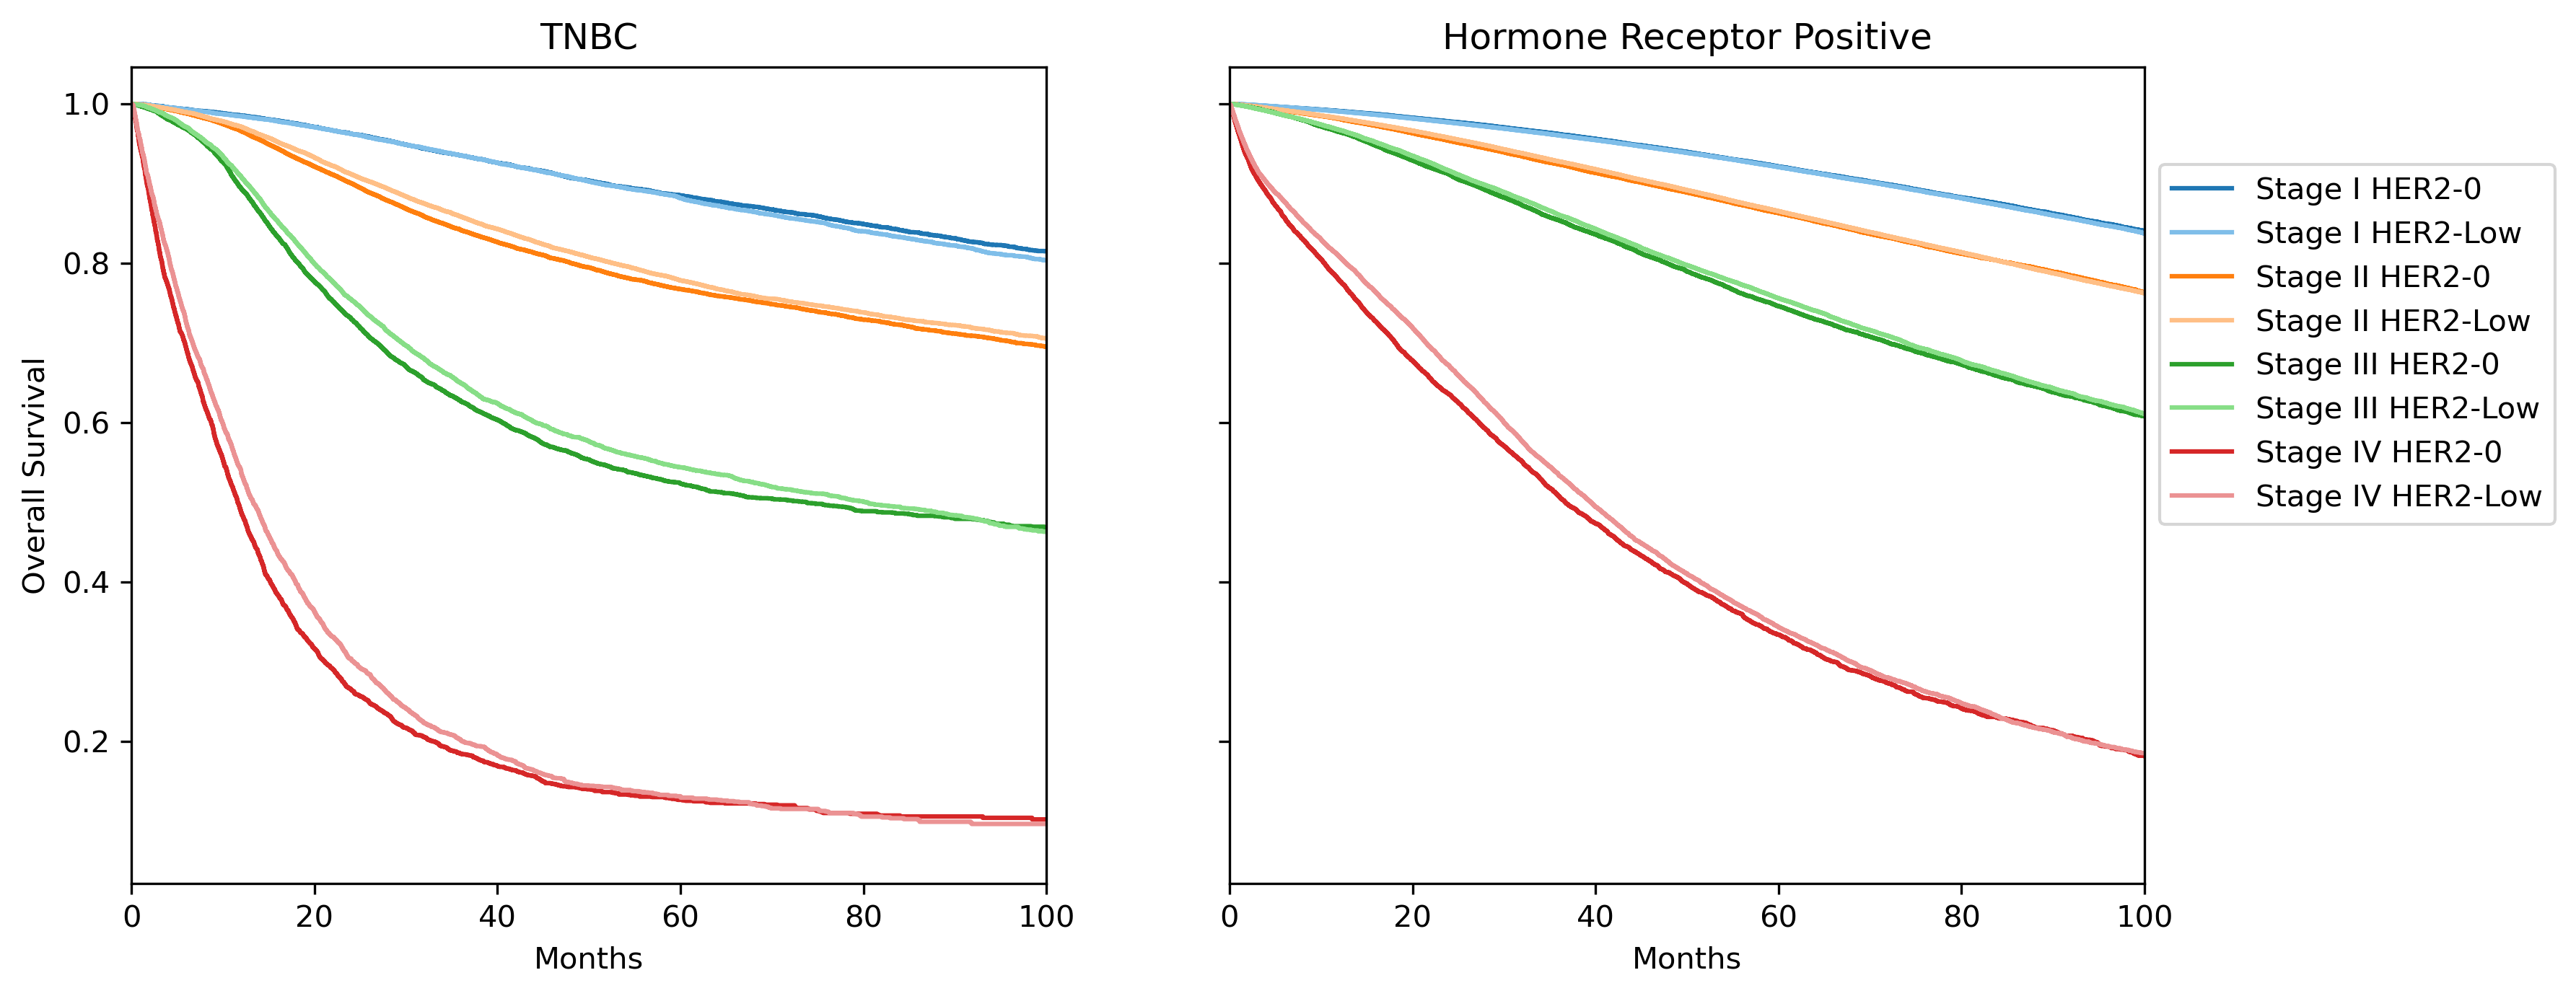

In [52]:
fig, ax = plt.subplots(1, 2, dpi = 300, figsize=(12,5), sharey=True)
plot_survival_stage(df[(df.receptors.astype(float) == 0)], ax[0], "TNBC")
plot_survival_stage(df[(df.receptors.astype(float) > 0)], ax[1], "Hormone Receptor Positive", legend=True)

plt.savefig("Figure 1.png", bbox_inches='tight')
plt.show()

We can output the same results as a table

In [53]:
def stringSurvTime(kmf, yr = 5, rnd_fig = 1):
    siga = kmf.confidence_interval_survival_function_[kmf.confidence_interval_survival_function_.index >= 12*yr]
    return str(round(100*kmf.predict(12*yr),rnd_fig)) + " (" + str(round(100*siga.values.tolist()[0][0],rnd_fig)) + " - " +  str(round(100*siga.values.tolist()[0][1],rnd_fig))  + "),"


def roundp(p, peq = False):
    """Return a formatted string for p values
    
    Parameters
    ----------
    p - p value float
    peq - True if need to include 'p' in the resulting string

    Returns
    -------
    Formatted p value string

    """
    if p < 0.01:
        if peq:
            return "p < 0.01"
        else:
            return "< 0.01"
    else:
        if peq:
            return "p = " + str(round(p,2))
        else:
            return str(round(p,2))

def stringHR(cph, value, rnd_fig = 2):
    cis = cph.confidence_intervals_[cph.confidence_intervals_.index == value].values.tolist()[0]
    return str(round(cph.hazard_ratios_[value],rnd_fig)) + " (" + str(round(math.exp(cis[0]),rnd_fig)) + " - " + str(round(math.exp(cis[1]),rnd_fig)) + ")," + roundp(cph.summary.p[value]) + ","


YEAR_MEASURE = 5
print("-,ALL,-,-,-,-,-,TNBC,-,-,-,-,-,HR+,-,-,-,-,-")
print("Stage,n HER2 0,n HER2 Low,5 Yr OS HER2 0,5 Yr OS HER2 Low,HR,p,n HER2 0,n HER2 Low,5 Yr OS HER2 0,5 Yr OS HER2 Low,HR,p,n HER2 0,n HER2 Low,5 Yr OS HER2 0,5 Yr OS HER2 Low,HR,p")
for s in [1,2,3,4]:
    printS = str(s) +","
    for subset in ['all', 'tnbc', 'hr']:
        if subset == 'all':
            df_subset = df.copy()
        elif subset == 'tnbc':
            df_subset = df[df.receptors.astype(float) == 0].copy()
        elif subset == 'hr':
            df_subset = df[df.receptors.astype(float) > 0].copy()
        #Lets create a new dataframe that only contains the stage we're interested in
        df_subset = df_subset[df_subset.stage.astype(float).isin([s])]

        #Now we create a subset of that subset that has only HER2 0+ patients
        df_subset_HER2_0 = df_subset[df_subset.her2.astype(float) == 0]

        #Now we create a subset with only the HER2-low patients
        df_subset_HER2_low = df_subset[df_subset.her2.astype(float) > 0]
        
        #To plot survival, we only need two variables - the last time of contact, and whether they were alive
        df_subset_HER2_0 = df_subset_HER2_0[['last_contact', 'alive']]
        df_subset_HER2_low = df_subset_HER2_low[['last_contact', 'alive']]

        #There are some missing values, so we need to remove any missing values to plot:
        df_subset_HER2_0 = df_subset_HER2_0.dropna()
        df_subset_HER2_low = df_subset_HER2_low.dropna()

        #Declare a new Kaplan Meier Fitter
        kmf = KaplanMeierFitter()
        printS += str(len(df_subset_HER2_0.index)) + "," + str(len(df_subset_HER2_low.index)) + ","
        #Fit the curve to the HER2 0+ data, and give a label with the Stage, HER2 0+, and # of patients
        kmf.fit(df_subset_HER2_0['last_contact'], df_subset_HER2_0['alive'], label='Stage ' + str(s) + ' HER2 0')# n = ' + str(len(df_subset_HER2_0.index)))
        printS += stringSurvTime(kmf, YEAR_MEASURE)

        kmf = KaplanMeierFitter()
        kmf.fit(df_subset_HER2_low['last_contact'], df_subset_HER2_low['alive'], label='Stage ' + str(s) + ' HER2-Low')# n = ' + str(len(df_subset_HER2_low.index)))
        printS += stringSurvTime(kmf, YEAR_MEASURE)
    
        
        cph = CoxPHFitter()
        df_subset['her2low'] = 0
        df_subset.loc[df_subset.her2.astype(float) > 0, 'her2low'] = 1
        df_cph = df_subset[['last_contact', 'alive', 'her2low']].dropna()
        cph.fit(df_cph, "last_contact", event_col = "alive")
        printS += stringHR(cph, "her2low")
    print(printS)

-,ALL,-,-,-,-,-,TNBC,-,-,-,-,-,HR+,-,-,-,-,-
Stage,n HER2 0,n HER2 Low,5 Yr OS HER2 0,5 Yr OS HER2 Low,HR,p,n HER2 0,n HER2 Low,5 Yr OS HER2 0,5 Yr OS HER2 Low,HR,p,n HER2 0,n HER2 Low,5 Yr OS HER2 0,5 Yr OS HER2 Low,HR,p
1,190665,376874,91.6 (91.5 - 91.8),91.8 (91.7 - 91.9),1.0 (0.98 - 1.02),0.78,25056,25568,88.5 (88.1 - 89.0),88.2 (87.7 - 88.6),1.05 (1.0 - 1.1),0.06,164484,348786,92.1 (92.0 - 92.3),92.1 (92.0 - 92.2),1.02 (1.0 - 1.04),0.05,
2,99361,189470,83.6 (83.3 - 83.9),85.2 (85.0 - 85.4),0.91 (0.89 - 0.93),< 0.01,28136,28353,76.8 (76.2 - 77.3),77.9 (77.3 - 78.4),0.94 (0.9 - 0.97),< 0.01,70603,159750,86.3 (86.0 - 86.6),86.5 (86.4 - 86.7),0.99 (0.96 - 1.01),0.24,
3,30939,57392,67.7 (67.1 - 68.3),71.8 (71.4 - 72.2),0.87 (0.85 - 0.89),< 0.01,9920,10410,52.4 (51.2 - 53.5),54.4 (53.3 - 55.5),0.95 (0.91 - 0.99),0.01,20811,46549,74.6 (74.0 - 75.3),75.6 (75.2 - 76.0),0.97 (0.94 - 1.0),0.04,
4,15448,27785,27.9 (27.0 - 28.7),31.2 (30.5 - 31.8),0.86 (0.84 - 0.88),< 0.01,4003,3850,12.7 (11.4

Now we can fit a Cox model with more variables

In [54]:
def setDummies(df, var, subset):
    ret_cols = []
    for v in subset:
        df[var + "_" + str(v)] = 0
        ret_cols += [var  + "_" +  str(v)]
        df.loc[df[var] == v, var  + "_" + str(v)] = 1
    return ret_cols

def parse_columns(df_subset, cols, ignore = [], include_stage4 = True, all_histologies = True, her2_categories = False):
    df_subset = df_subset[cols].dropna()
    print(len(df_subset[df_subset.her2 == 0].index))
    print(len(df_subset[df_subset.her2 == 1].index))
    print(len(df_subset[df_subset.her2 == 2].index))
    cols = [c for c in cols if c not in ignore]
    test_cols = []
    label_cols = []
    label_names = []

    if 'age' in cols:
        test_cols += ['age']
        label_cols += [['age']]
        label_names += [['Age (per year)']]
        df_subset['age'] = df_subset['age'] / 10
    if 'cdcc' in cols:
        test_cols += ['cdcc']
        label_cols += [['cdcc']]
        label_names += [['CDCC 0', 'CDCC > 0']]
        df_subset['cdcc_high'] = 0
        df_subset.loc[df_subset.cdcc.astype(float) > 0, 'cdcc_high'] = 1

    if 'facility' in cols:
        t = setDummies(df_subset, 'facility', {2,3,4})
        test_cols += t
        label_cols += [t]
        label_names += [['Community Cancer Program', 'Comprehensive Comunity Cancer Program', 'Academic / Research', 'Integrated Network Cancer Program']]

    if 'receptors' in cols:
        if len(df_subset[df_subset.receptors.astype(float)==0].index > 0):
            test_cols += ['prneg', 'erneg', 'tnbc']
            label_cols += [['prneg', 'erneg', 'tnbc']]
            label_names += [['ER+', 'ER+/PR-', 'ER-/PR+', 'TNBC']]
            df_subset['prneg'] = 0
            df_subset['erneg'] = 0
            df_subset['tnbc'] = 0
            df_subset.loc[df_subset.receptors.astype(float) == 100, 'prneg'] = 1
            df_subset.loc[df_subset.receptors.astype(float) == 10, 'erneg'] = 1
            df_subset.loc[df_subset.receptors.astype(float) == 0, 'tnbc'] = 1
        else:
            test_cols += ['prneg', 'erneg']
            label_cols += [['prneg', 'erneg']]
            label_names += [['ER+', 'ER+/PR-', 'ER-/PR+']]
            df_subset['prneg'] = 0
            df_subset['erneg'] = 0
            df_subset.loc[df_subset.receptors.astype(float) == 100, 'prneg'] = 1
            df_subset.loc[df_subset.receptors.astype(float) == 10, 'erneg'] = 1

    if 'er_num' in cols:
        test_cols += ['er_num']
        label_cols += [['er_num']]
        label_names += [['ER (per % expression)']]

    if 'pr_num' in cols:
        test_cols += ['pr_num']
        label_cols += [['pr_num']]
        label_names += [['PR (per % expression)']]

    if 'ki67_num' in cols:
        test_cols += ['ki67_num']
        label_cols += [['ki67_num']]
        label_names += [['Ki67 (per % expression)']]

    if 'her2' in cols:
        if her2_categories:
            test_cols += ['her2_1', 'her2_2']
            label_cols += [['her2_1', 'her2_2']]
            label_names += [['HER2 0', 'HER2 1+', 'HER2 2+']]
            df_subset['her2_1'] = 0
            df_subset['her2_2'] = 0
            df_subset.loc[df_subset.her2.astype(float) == 1, 'her2_1'] = 1        
            df_subset.loc[df_subset.her2.astype(float) == 2, 'her2_2'] = 1        
        else:
            test_cols += ['her2low']
            label_cols += [['her2low']]
            label_names += [['HER2 0', 'HER2 Low']]
            df_subset['her2low'] = 0
            df_subset.loc[df_subset.her2.astype(float) > 0, 'her2low'] = 1

    if 'her2ratio' in cols:
        test_cols += ['her2ratio']
        label_cols += [['her2ratio']]
        label_names += [['HER2 Ratio (per 1.0 increase)']]

    if 'her2copies' in cols:
        test_cols += ['her2copies']
        label_cols += [['her2copies']]
        label_names += [['HER2 Count (per 1.0 increase)']]
    
    if 'odx' in cols:
        test_cols += ['odx']
        label_cols += [['odx']]
        label_names += [['OncotypeDx (per 1 point increase)']]
        
    if 'race_parse' in cols:
        t = setDummies(df_subset, 'race_parse', {1,2,3,4,5})
        test_cols += t
        label_cols += [t]
        label_names += [['Non-Hispanic White', 'Non-Hispanic Black', 'Hispanic', 'Other', 'Native American', 'Asian / Pacific Islander']]

    if 'tumor_size' in cols:
        test_cols += ['tumor_size']
        label_cols += [['tumor_size']]
        label_names += [['Tumor Size (per mm increase)']]
        
    if 'regional_nodes_positive' in cols:
        test_cols += ['regional_nodes_positive']
        label_cols += [['regional_nodes_positive']]
        label_names += [['Nodes Positive (per # of involved nodes)']]
        
    if 'tnm_clin_t' in cols:
        test_cols += ['t2', 't3', 't4']
        label_cols += [['t2', 't3', 't4']]
        label_names += [['T1', 'T2', 'T3', 'T4']]
        df_subset = df_subset[df_subset.tnm_clin_t.str.contains('1') | df_subset.tnm_clin_t.str.contains('2') | df_subset.tnm_clin_t.str.contains('3') | df_subset.tnm_clin_t.str.contains('4')].reset_index()
        df_subset['t2'] = 0
        df_subset['t3'] = 0
        df_subset['t4'] = 0
        df_subset.loc[df_subset.tnm_clin_t.str.contains('2'), 't2'] = 1
        df_subset.loc[df_subset.tnm_clin_t.str.contains('3'), 't3'] = 1
        df_subset.loc[df_subset.tnm_clin_t.str.contains('4'), 't4'] = 1

    if 'tnm_clin_n' in cols:
        test_cols += ['n1', 'n2', 'n3']
        label_cols += [['n1', 'n2', 'n3']]
        label_names += [['N0', 'N1', 'N2', 'N3']]
        df_subset = df_subset[df_subset.tnm_clin_n.str.contains('0') | df_subset.tnm_clin_n.str.contains('1') | df_subset.tnm_clin_n.str.contains('2') | df_subset.tnm_clin_n.str.contains('3')].reset_index()
        df_subset['n1'] = 0
        df_subset['n2'] = 0
        df_subset['n3'] = 0
        df_subset.loc[df_subset.tnm_clin_n.str.contains('1'), 'n1'] = 1
        df_subset.loc[df_subset.tnm_clin_n.str.contains('2'), 'n2'] = 1
        df_subset.loc[df_subset.tnm_clin_n.str.contains('3'), 'n3'] = 1
        
    if 't_stage' in cols:
        df_subset = df_subset[df_subset.t_stage.isin([1,2,3,4])].reset_index()
        test_cols += ['t2', 't3', 't4']
        label_cols += [['t2', 't3', 't4']]
        label_names += [['T1', 'T2', 'T3', 'T4']]
        df_subset['t2'] = 0
        df_subset['t3'] = 0
        df_subset['t4'] = 0
        df_subset.loc[df_subset.t_stage == 2, 't2'] = 1
        df_subset.loc[df_subset.t_stage == 3, 't3'] = 1
        df_subset.loc[df_subset.t_stage == 4, 't4'] = 1

    if 'n_stage' in cols:
        test_cols += ['n1', 'n2', 'n3']
        label_cols += [['n1', 'n2', 'n3']]
        label_names += [['N0', 'N1', 'N2', 'N3']]
        df_subset = df_subset[df_subset.n_stage.isin([0,1,2,3])].reset_index()
        df_subset['n1'] = 0
        df_subset['n2'] = 0
        df_subset['n3'] = 0
        df_subset.loc[df_subset.n_stage == 1, 'n1'] = 1
        df_subset.loc[df_subset.n_stage == 2, 'n2'] = 1
        df_subset.loc[df_subset.n_stage == 3, 'n3'] = 1
        
    if 'stage' in cols:
        if include_stage4:
            t = setDummies(df_subset, 'stage', {2,3,4})
            test_cols += t
            label_cols += [t]
            label_names += [['Stage 1', 'Stage 2', 'Stage 3', 'Stage 4']]
        else:
            t = setDummies(df_subset, 'stage', {2,3})
            test_cols += t
            label_cols += [t]
            label_names += [['Stage 1', 'Stage 2', 'Stage 3']]
            
    if 'grade' in cols:
        t = setDummies(df_subset, 'grade', {2,3})
        test_cols += t
        label_cols += [t]
        label_names += [['Grade 1', 'Grade 2', 'Grade 3']]
        
    if 'histology' in cols:
        if all_histologies:
            t = setDummies(df_subset, 'histology', {1,2,3,4,5,6,7,8,9,10})
            test_cols += t + ['histology_others']
            label_cols += [t + ['histology_others']]
            df_subset['histology_others'] = 0
            df_subset.loc[~df_subset.histology.isin([0,1,2,3,4,5,6,7,8,9,10]), 'histology_others'] = 1
            label_names += [['Ductal', 'Lobular', 'Ductal and Lobular', 'Mucinous', 'Papillary', 'Tubular', 'Inflammatory', 'Medullary', 'Metaplastic', 'Paget Disease', 'Sarcoma', 'Other']]

        else:
            t = setDummies(df_subset, 'histology', {1,2,3})
            test_cols += t + ['histology_others']
            label_cols += [t + ['histology_others']]
            df_subset['histology_others'] = 0
            df_subset.loc[~df_subset.histology.isin([0,1,2,3]), 'histology_others'] = 1
            label_names += [['Ductal', 'Lobular', 'Ductal and Lobular', 'Mucinous']]
    return df_subset, test_cols, label_cols, label_names

def cphModelMultivariate(df_subset, cols, all_histologies = True, her2_categories = False):
    df_subset, test_cols, label_cols, label_names = parse_columns(df_subset, cols, all_histologies = all_histologies, her2_categories = her2_categories)
    print('n = ' + str(len(df_subset.index)))
    test_cols += ['alive', 'last_contact']
    cph = CoxPHFitter(penalizer=0.1)
    df_cph = df_subset[test_cols]
    cph.fit(df_cph, "last_contact", event_col = "alive")
    for l, n in zip(label_cols, label_names):
        if len(n) == 1:
            print(n[0] + "," + stringHR(cph, l[0]))
        if len(n) > 1:
            print(n[0] + ",-,-")
            for l_sub, n_sub in zip(l, n[1:]):
                print(n_sub + "," + stringHR(cph, l_sub))            



                #cols = ['age', 'race_parse', 'stage', 'receptors', 'grade', 'histology', 'her2ratio', 'her2copies', 'alive', 'last_contact']


In [55]:
#Set her2_cat to True if you want to split analyses by HER2 0 vs 1+ vs 2+
her2_cat = False
print("Model for all patients")
cphModelMultivariate(df.copy(), ['age', 'race_parse', 'cdcc', 'facility', 'stage', 'grade', 'histology', 'receptors', 'her2', 'alive', 'last_contact'], her2_categories = her2_cat)
print()
print("Model for all patients including ER/PR quantitative status")
cphModelMultivariate(df.copy(), ['age', 'race_parse', 'cdcc', 'facility', 'stage', 'grade', 'histology', 'receptors', 'er_num', 'pr_num', 'her2', 'alive', 'last_contact'], all_histologies = False, her2_categories = her2_cat)

var_list = ['age', 'race_parse', 'cdcc', 'facility', 'grade', 'histology', 'her2', 'alive', 'last_contact']
index = 1
for s in [stage1, stage2, stage3, stage4]:
    print()
    print("Model TNBC - stage " + str(index))
    cphModelMultivariate(s[s.receptors.isin([0])].copy(), var_list, all_histologies = False, her2_categories = her2_cat)
    index = index + 1

var_list = ['age', 'race_parse', 'cdcc', 'facility', 'receptors', 'grade', 'histology', 'her2', 'alive', 'last_contact']
index = 1
for s in [stage1, stage2, stage3, stage4]:
    print()
    print("Model HR+ - stage " + str(index))
    cphModelMultivariate(s[s.receptors > 0].copy(), var_list, all_histologies = False, her2_categories = her2_cat)
    index = index + 1
    
print()
print("Model for HR+ patients who had OncotypeDx Testing")
cphModelMultivariate(df[df.receptors > 0].copy(), ['age', 'race_parse', 'stage', 'grade', 'histology', 'odx', 'her2', 'alive', 'last_contact'], all_histologies = False, her2_categories = her2_cat)


Model for all patients
301018
435254
153448
n = 889720
Age (per year),1.39 (1.39 - 1.4),< 0.01,
CDCC 0,-,-
CDCC > 0,1.31 (1.3 - 1.32),< 0.01,
Community Cancer Program,-,-
Comprehensive Comunity Cancer Program,1.01 (1.0 - 1.02),0.01,
Academic / Research,0.91 (0.91 - 0.92),< 0.01,
Integrated Network Cancer Program,0.98 (0.97 - 1.0),< 0.01,
ER+,-,-
ER+/PR-,1.2 (1.18 - 1.22),< 0.01,
ER-/PR+,1.5 (1.44 - 1.57),< 0.01,
TNBC,1.44 (1.42 - 1.45),< 0.01,
HER2 0,-,-
HER2 Low,0.98 (0.97 - 0.99),< 0.01,
Non-Hispanic White,-,-
Non-Hispanic Black,1.17 (1.15 - 1.18),< 0.01,
Hispanic,0.89 (0.87 - 0.91),< 0.01,
Other,0.84 (0.79 - 0.9),< 0.01,
Native American,1.11 (1.02 - 1.2),0.01,
Asian / Pacific Islander,0.81 (0.79 - 0.83),< 0.01,
Stage 1,-,-
Stage 2,1.21 (1.2 - 1.22),< 0.01,
Stage 3,2.1 (2.07 - 2.13),< 0.01,
Stage 4,7.2 (7.09 - 7.32),< 0.01,
Grade 1,-,-
Grade 2,1.0 (0.99 - 1.01),0.49,
Grade 3,1.34 (1.32 - 1.35),< 0.01,
Ductal,-,-
Lobular,1.01 (1.0 - 1.02),0.1,
Ductal and Lobular,0.96 (0.94 - 0.98),< 0

Lobular,0.99 (0.96 - 1.02),0.58,
Ductal and Lobular,0.94 (0.89 - 0.99),0.01,
Mucinous,1.05 (0.9 - 1.22),0.56,

Model HR+ - stage 4
8040
12726
5141
n = 25907
Age (per year),1.19 (1.18 - 1.21),< 0.01,
CDCC 0,-,-
CDCC > 0,1.2 (1.17 - 1.23),< 0.01,
Community Cancer Program,-,-
Comprehensive Comunity Cancer Program,0.99 (0.95 - 1.03),0.72,
Academic / Research,0.87 (0.84 - 0.91),< 0.01,
Integrated Network Cancer Program,0.96 (0.91 - 1.01),0.08,
ER+,-,-
ER+/PR-,1.38 (1.33 - 1.44),< 0.01,
ER-/PR+,2.19 (1.97 - 2.42),< 0.01,
HER2 0,-,-
HER2 Low,0.95 (0.92 - 0.99),< 0.01,
Non-Hispanic White,-,-
Non-Hispanic Black,1.21 (1.16 - 1.26),< 0.01,
Hispanic,0.87 (0.81 - 0.94),< 0.01,
Other,0.69 (0.56 - 0.86),< 0.01,
Native American,0.93 (0.73 - 1.19),0.56,
Asian / Pacific Islander,0.83 (0.75 - 0.91),< 0.01,
Grade 1,-,-
Grade 2,1.0 (0.96 - 1.04),0.89,
Grade 3,1.39 (1.33 - 1.45),< 0.01,
Ductal,-,-
Lobular,1.12 (1.07 - 1.16),< 0.01,
Ductal and Lobular,0.98 (0.92 - 1.05),0.56,
Mucinous,0.9 (0.76 - 1.06),0.21,

# Multivariate Demographic / Clinicopathologic Feature Analysis 

In [56]:
def stringBeta(log_reg, v, rnd_fig = 2):
    return str(round(np.exp(log_reg.params[v]), rnd_fig)) + " (" + str(round(np.exp(log_reg.conf_int()[0][v]), rnd_fig)) + " - " + str(round(np.exp(log_reg.conf_int()[1][v]), rnd_fig)) + ")," + roundp(log_reg.pvalues[v]) + ","

def logitHER2Low(df_subset, cols):
    df_subset, test_cols, label_cols, label_names = parse_columns(df_subset, cols, ignore = ['her2'], all_histologies = True, her2_categories = True)

    # Compare other race / ethnicities to non-hispanic white
    df_subset['her2low'] = np.nan
    df_subset.loc[df_subset.her2 == 0, 'her2low'] = 0
    df_subset.loc[df_subset.her2 > 0, 'her2low'] = 1
    df_subset = df_subset.dropna(subset = ['her2low'])

    print('n = ' + str(len(df_subset.index)))

    Xtrain = df_subset[test_cols]
    ytrain = df_subset[['her2low']]


    # building the model and fitting the data
    log_reg = sm.Logit(ytrain, Xtrain).fit(disp = 0)


    for l, n in zip(label_cols, label_names):
        if len(n) == 1:
            print(n[0] + "," + stringBeta(log_reg, l[0]))
        if len(n) > 1:
            print(n[0] + ",-,-")
            for l_sub, n_sub in zip(l, n[1:]):
                print(n_sub + "," + stringBeta(log_reg, l_sub))            

    #print(log_reg.summary())
    
print("Distinguishing HER2 0 vs low")
logitHER2Low(df.copy(), ['age', 'race_parse', 'cdcc', 'facility', 'stage', 'receptors', 'grade', 'histology', 'her2', 'alive', 'last_contact'])


Distinguishing HER2 0 vs low
301018
435254
153448
n = 889720
Age (per year),1.09 (1.09 - 1.1),< 0.01,
CDCC 0,-,-
CDCC > 0,0.99 (0.98 - 0.99),< 0.01,
Community Cancer Program,-,-
Comprehensive Comunity Cancer Program,1.34 (1.32 - 1.36),< 0.01,
Academic / Research,1.06 (1.04 - 1.07),< 0.01,
Integrated Network Cancer Program,1.32 (1.3 - 1.35),< 0.01,
ER+,-,-
ER+/PR-,0.88 (0.87 - 0.89),< 0.01,
ER-/PR+,0.61 (0.58 - 0.64),< 0.01,
TNBC,0.47 (0.46 - 0.47),< 0.01,
Non-Hispanic White,-,-
Non-Hispanic Black,1.04 (1.02 - 1.05),< 0.01,
Hispanic,0.88 (0.86 - 0.9),< 0.01,
Other,0.86 (0.81 - 0.92),< 0.01,
Native American,1.29 (1.18 - 1.41),< 0.01,
Asian / Pacific Islander,1.06 (1.03 - 1.08),< 0.01,
Stage 1,-,-
Stage 2,1.13 (1.12 - 1.14),< 0.01,
Stage 3,1.16 (1.14 - 1.18),< 0.01,
Stage 4,1.09 (1.07 - 1.12),< 0.01,
Grade 1,-,-
Grade 2,1.08 (1.06 - 1.09),< 0.01,
Grade 3,1.01 (1.0 - 1.03),0.13,
Ductal,-,-
Lobular,0.75 (0.74 - 0.77),< 0.01,
Ductal and Lobular,0.87 (0.86 - 0.89),< 0.01,
Mucinous,0.5 (0.48 -

# Is HER2 Low a Predictor of Neoadjuvant Response?

Describe the baseline demographics of the neoadjuvant chemo population

In [57]:
def baselineCharacteristicsPCR(df):
    """Generate baseline characteristics table, prints results into console

        Parameters
        ----------
        df - dataframe to use
        """
    print(df['last_contact'].median())
    columns = ['age', 'age_group', 'sex', 'race_parse', 'facility', 'cdcc', 'year', 'grade', 'histology', 'tumor_size', 'reg_node_cat', 't_stage', 'n_stage', 'stage', 'mets_bone', 
               'mets_brain', 'mets_liver', 'mets_lung', 'her2_group', 'her2ratio', 'her2copies', 'receptors', 'er_num', 'pr_num', 'ki67_num', 'recurrence_score_group', 'hormone', 'pcr', 'last_contact', 'alive']
    labels = {'age':'Age', 'age_group':'Age Group', 'sex':'Sex', 'race_parse':'Race / Ethnicity', 'cdcc':'Charlson/Dayo Score', 'facility':'Facility Type', 'year':'Diagnosis Year', 
              'grade':'Grade', 'histology':'Histologic Subtype', 'tumor_size':'Tumor Size (mm)', 'reg_node_cat':'Lymph Node Status', 't_stage':'T Stage', 'n_stage':'N Stage', 'stage':'Stage', 'mets_bone':'Bone Mets at Diagnosis', 'mets_brain':'Brain Mets at Diagnosis', 'mets_liver':'Liver Mets at Diagnosis', 'mets_lung':'Lung Mets at Diagnosis',
              'her2_group':'HER2 Group', 'her2ratio':'HER2/CEP17 Ratio', 'her2copies':'HER2 Copies', 'receptors':'Receptor Status', 'er_num':'ER (% Positive)', 'pr_num':'PR (% Positive)', 'ki67_num':'Ki67 (% Positive)',
              'recurrence_score_group':'OncotypeDx Score', 'chemo':'Chemotherapy', 'hormone':'Hormonal Therapy', 'pcr':'pCR Status', 'last_contact':'Last Contact Months', 'alive':'Vital Status'}
    categorical = ['age_group', 'sex', 'race_parse', 'facility', 'cdcc', 'grade', 'histology', 'reg_node_cat', 't_stage', 'n_stage', 'stage', 'mets_bone', 'mets_brain', 'mets_liver', 'mets_lung', 'receptors', 'recurrence_score_group', 'hormone', 'alive', 'pcr']
    for c in ['odx', 'race_parse', 'facility', 'cdcc', 'histology', 'regional_nodes_positive', 'receptors', 'recurrence_score', 'hormone', 'pcr']:
        df[c] = pd.to_numeric(df[c], errors='coerce')
    df['age_group'] = np.nan
    df.loc[df.age < 40, 'age_group'] = '< 40'
    df.loc[df.age >= 40, 'age_group'] = '40 - 49'
    df.loc[df.age >= 50, 'age_group'] = '50 - 59'
    df.loc[df.age >= 60, 'age_group'] = '60 - 69'
    df.loc[df.age >= 70, 'age_group'] = '70 - 79'
    df.loc[df.age >= 80, 'age_group'] = '80+'
    df['sex'] = df.sex.map({1:'Male', 2:'Female'})
    df['race_parse'] = df.race_parse.map({0:'Non-Hispanic White', 1:'Non-Hispanic Black', 2:'Hispanic', 3:'Other', 4:'Native American', 5:'Asian'})
    df['facility'] = df.facility.map({1:'Community Cancer Program', 2:'Comprehensive Comunity Cancer Program', 3:'Academic / Research', 4:'Integrated Network Cancer Program'})
    df['cdcc'] = df.cdcc.map({0: '0', 1: '>= 1', 2: '>= 1', 3: '>= 1'})
    df['histology'] = df.histology.map({0: 'Ductal', 1: 'Lobular', 2: 'Ductal and Lobular', 
                                        3: 'Mucinous', 4: 'Papillary', 5: 'Tubular', 6: 'Inflammatory',
                                        7: 'Medullary', 8: 'Metaplastic', 9: 'Paget Disease', 10: 'Sarcoma',
                                        11: 'Others'})
    df['reg_node_cat'] = '0 Positive'
    df.loc[df.regional_nodes_positive.isin([1]), 'reg_node_cat'] = '1 Node'
    df.loc[(df.regional_nodes_positive > 1) & (df.regional_nodes_positive <= 90), 'reg_node_cat'] = '2+ Nodes'
    df['her2_group'] = 'HER2 0'
    df.loc[df.her2 > 0, 'her2_group'] = 'HER2 Low'
    df['receptors'] = df.receptors.map({0:'TNBC', 10:'ER-PR+', 100:'ER+PR-', 110:'ER+PR+'})
    df['alive'] = df.alive.map({0: 'Alive', 1: 'Deceased'})
    df.loc[df.odx >= 0, 'recurrence_score_group'] = "Low (0 - 10)"
    df.loc[df.odx >= 11, 'recurrence_score_group'] = "Intermediate (11 - 25)"
    df.loc[df.odx >= 26, 'recurrence_score_group'] = "High (26+)"
    df['hormone'] = df.hormone.map({0: 'No Hormonal Therapy', 1: 'Hormonal Therapy'})
    df['pcr'] = df.pcr.map({0: 'Residual Disease', 1: 'pCR'})
    
    mytable = TableOne(df, columns=columns, categorical=categorical, groupby='her2_group', pval=True, labels = labels)
    print(mytable.tabulate(tablefmt="github"))
    #mytable.to_excel('table two.xlsx')

    mytable = TableOne(df, columns=columns, categorical=categorical, groupby='her2_group', pval=True, row_percent=True, labels = labels)
    print(mytable.tabulate(tablefmt="github"))
    #mytable.to_excel('table two - row percents.xlsx')

    
#baselineCharacteristicsPCR(df[(df.neoadj_chemo == 1) & (df.stage < 4)].copy())
baselineCharacteristicsPCR(df[(df.neoadj_chemo == 1) & (df.stage < 4) & (df.receptors.isin([110,10,100]))].copy())
baselineCharacteristicsPCR(df[(df.neoadj_chemo == 1) & (df.stage < 4) & (df.receptors.isin([0]))].copy())

52.34
|                                |                                       | Missing   | Overall       | HER2 0        | HER2 Low      | P-Value   |
|--------------------------------|---------------------------------------|-----------|---------------|---------------|---------------|-----------|
| n                              |                                       |           | 61876         | 19444         | 42432         |           |
| Age, mean (SD)                 |                                       | 0         | 53.4 (12.0)   | 53.1 (12.0)   | 53.6 (12.1)   | <0.001    |
| Age Group, n (%)               | 40 - 49                               | 0         | 15398 (24.9)  | 5026 (25.8)   | 10372 (24.4)  | <0.001    |
|                                | 50 - 59                               |           | 17692 (28.6)  | 5406 (27.8)   | 12286 (29.0)  |           |
|                                | 60 - 69                               |           | 14580 (23.6)  | 4530 (23.

|                                |                                       | Missing   | Overall       | HER2 0       | HER2 Low     | P-Value   |
|--------------------------------|---------------------------------------|-----------|---------------|--------------|--------------|-----------|
| n                              |                                       |           | 61876         | 19444        | 42432        |           |
| Age, mean (SD)                 |                                       | 0         | 53.4 (12.0)   | 53.1 (12.0)  | 53.6 (12.1)  | <0.001    |
| Age Group, n (%)               | 40 - 49                               | 0         | 15398 (100.0) | 5026 (32.6)  | 10372 (67.4) | <0.001    |
|                                | 50 - 59                               |           | 17692 (100.0) | 5406 (30.6)  | 12286 (69.4) |           |
|                                | 60 - 69                               |           | 14580 (100.0) | 4530 (31.1)  | 10050 (68.9)

44.02
|                                |                                       | Missing   | Overall       | HER2 0        | HER2 Low      | P-Value   |
|--------------------------------|---------------------------------------|-----------|---------------|---------------|---------------|-----------|
| n                              |                                       |           | 47142         | 24361         | 22781         |           |
| Age, mean (SD)                 |                                       | 0         | 53.2 (12.4)   | 52.7 (12.4)   | 53.7 (12.4)   | <0.001    |
| Age Group, n (%)               | 40 - 49                               | 0         | 11403 (24.2)  | 6018 (24.7)   | 5385 (23.6)   | <0.001    |
|                                | 50 - 59                               |           | 13680 (29.0)  | 7015 (28.8)   | 6665 (29.3)   |           |
|                                | 60 - 69                               |           | 10162 (21.6)  | 5046 (20.

|                                |                                       | Missing   | Overall       | HER2 0       | HER2 Low     | P-Value   |
|--------------------------------|---------------------------------------|-----------|---------------|--------------|--------------|-----------|
| n                              |                                       |           | 47142         | 24361        | 22781        |           |
| Age, mean (SD)                 |                                       | 0         | 53.2 (12.4)   | 52.7 (12.4)  | 53.7 (12.4)  | <0.001    |
| Age Group, n (%)               | 40 - 49                               | 0         | 11403 (100.0) | 6018 (52.8)  | 5385 (47.2)  | <0.001    |
|                                | 50 - 59                               |           | 13680 (100.0) | 7015 (51.3)  | 6665 (48.7)  |           |
|                                | 60 - 69                               |           | 10162 (100.0) | 5046 (49.7)  | 5116 (50.3) 

In [58]:
def logitNAC(df_subset, cols, all_histologies = True, her2_categories = False):
    df_subset, test_cols, label_cols, label_names = parse_columns(df_subset, cols, ignore = ['pCR'], include_stage4 = False, all_histologies = all_histologies, her2_categories = her2_categories)

    print('n = ' + str(len(df_subset.index)))
    
    Xtrain = df_subset[test_cols]
    ytrain = df_subset[['pcr']]

    # building the model and fitting the data
    log_reg = sm.Logit(ytrain, Xtrain).fit(disp = 0)


    for l, n in zip(label_cols, label_names):
        if len(n) == 1:
            print(n[0] + "," + stringBeta(log_reg, l[0]))
        if len(n) > 1:
            print(n[0] + ",-,-")
            for l_sub, n_sub in zip(l, n[1:]):
                print(n_sub + "," + stringBeta(log_reg, l_sub))            

#Set to True to analyze 0 vs 1+ vs 2+ HER2
her2_cat = False
print()
print("Analysis for pCR to NAC including Clinical T/N stage instead of analytic stage group")
logitNAC(df[(df.neoadj_chemo == 1) & (df.stage < 4)].copy(), ['age', 'race_parse', 'cdcc', 'facility', 't_stage', 'n_stage', 'receptors', 'grade', 'histology', 'her2', 'pcr'], her2_categories = her2_cat)

print()
print("Analysis for pCR to NAC including Clinical T/N stage in just TNBC")
logitNAC(df[(df.neoadj_chemo == 1) & (df.stage < 4) & (df.receptors == 0)].copy(), ['age', 'race_parse', 'cdcc', 'facility', 't_stage', 'n_stage', 'grade', 'histology', 'her2', 'pcr'], all_histologies = False, her2_categories = her2_cat)

print()
print("Analysis for pCR to NAC including ER/PR and Clinical T/N stage instead of analytic stage group")
logitNAC(df[(df.neoadj_chemo == 1) & (df.stage < 4)].copy(), ['age', 'race_parse', 'cdcc', 'facility', 't_stage', 'n_stage', 'receptors', 'er_num', 'pr_num', 'grade', 'histology', 'her2', 'pcr'], all_histologies = False, her2_categories = her2_cat)


Analysis for pCR to NAC including Clinical T/N stage instead of analytic stage group
33657
35851
15091
n = 84440


C:\Users\fhowa\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
<ipython-input-56-7edd00765056>:2: RuntimeWarning: overflow encountered in exp
  return str(round(np.exp(log_reg.params[v]), rnd_fig)) + " (" + str(round(np.exp(log_reg.conf_int()[0][v]), rnd_fig)) + " - " + str(round(np.exp(log_reg.conf_int()[1][v]), rnd_fig)) + ")," + roundp(log_reg.pvalues[v]) + ","


Age (per year),0.77 (0.76 - 0.78),< 0.01,
CDCC 0,-,-
CDCC > 0,0.96 (0.92 - 0.99),0.02,
Community Cancer Program,-,-
Comprehensive Comunity Cancer Program,0.82 (0.76 - 0.88),< 0.01,
Academic / Research,0.83 (0.78 - 0.9),< 0.01,
Integrated Network Cancer Program,0.83 (0.77 - 0.9),< 0.01,
ER+,-,-
ER+/PR-,2.87 (2.68 - 3.07),< 0.01,
ER-/PR+,3.98 (3.57 - 4.43),< 0.01,
TNBC,4.02 (3.81 - 4.24),< 0.01,
HER2 0,-,-
HER2 Low,0.87 (0.84 - 0.9),< 0.01,
Non-Hispanic White,-,-
Non-Hispanic Black,0.87 (0.83 - 0.91),< 0.01,
Hispanic,0.94 (0.88 - 1.01),0.07,
Other,0.88 (0.69 - 1.13),0.33,
Native American,0.87 (0.63 - 1.2),0.39,
Asian / Pacific Islander,0.87 (0.79 - 0.96),< 0.01,
T1,-,-
T2,0.69 (0.66 - 0.72),< 0.01,
T3,0.46 (0.43 - 0.49),< 0.01,
T4,0.43 (0.39 - 0.46),< 0.01,
N0,-,-
N1,0.74 (0.71 - 0.77),< 0.01,
N2,0.69 (0.64 - 0.75),< 0.01,
N3,0.77 (0.7 - 0.84),< 0.01,
Grade 1,-,-
Grade 2,0.59 (0.53 - 0.64),< 0.01,
Grade 3,1.29 (1.18 - 1.41),< 0.01,
Ductal,-,-
Lobular,0.45 (0.39 - 0.51),< 0.01,
Ductal and

# Analysis of Metastatic Sites

In [59]:
def logitMets(df_subset, cols, outcome, all_histologies = True, her2_categories = False):
    df_subset, test_cols, label_cols, label_names = parse_columns(df_subset, cols, ignore = [outcome], all_histologies = all_histologies, her2_categories = her2_categories)

    print('n = ' + str(len(df_subset.index)))
    
    Xtrain = df_subset[test_cols]
    ytrain = df_subset[[outcome]]

    # building the model and fitting the data
    log_reg = sm.Logit(ytrain, Xtrain).fit(disp = 0, maxiter=200)


    for l, n in zip(label_cols, label_names):
        if len(n) == 1:
            print(n[0] + "," + stringBeta(log_reg, l[0]))
        if len(n) > 1:
            print(n[0] + ",-,-")
            for l_sub, n_sub in zip(l, n[1:]):
                print(n_sub + "," + stringBeta(log_reg, l_sub))            

print()
print("Analysis for brain mets")
logitMets(df[(df.stage == 4)].copy(), ['age', 'race_parse', 'cdcc', 'facility', 'receptors', 'grade', 'histology', 'her2', 'mets_brain'], 'mets_brain', all_histologies = False)

print("Analysis for lung mets")
logitMets(df[df.stage == 4].copy(), ['age', 'race_parse', 'cdcc', 'facility', 'receptors', 'grade', 'histology', 'her2', 'mets_lung'], 'mets_lung', all_histologies = False)

print("Analysis for liver mets")
logitMets(df[df.stage == 4].copy(), ['age', 'race_parse', 'cdcc', 'facility', 'receptors', 'grade', 'histology', 'her2', 'mets_liver'], 'mets_liver', all_histologies = False)

print("Analysis for bone mets")
logitMets(df[df.stage == 4].copy(), ['age', 'race_parse', 'cdcc', 'facility', 'receptors', 'grade', 'histology', 'her2', 'mets_bone'], 'mets_bone', all_histologies = False)


Analysis for brain mets
9572
12932
5287
n = 27791
Age (per year),0.72 (0.71 - 0.75),< 0.01,
CDCC 0,-,-
CDCC > 0,1.06 (0.98 - 1.14),0.13,
Community Cancer Program,-,-
Comprehensive Comunity Cancer Program,0.63 (0.54 - 0.73),< 0.01,
Academic / Research,0.63 (0.54 - 0.74),< 0.01,
Integrated Network Cancer Program,0.73 (0.62 - 0.86),< 0.01,
ER+,-,-
ER+/PR-,1.36 (1.18 - 1.58),< 0.01,
ER-/PR+,2.12 (1.54 - 2.92),< 0.01,
TNBC,1.91 (1.68 - 2.16),< 0.01,
HER2 0,-,-
HER2 Low,0.8 (0.73 - 0.89),< 0.01,
Non-Hispanic White,-,-
Non-Hispanic Black,0.75 (0.66 - 0.85),< 0.01,
Hispanic,0.82 (0.66 - 1.02),0.07,
Other,0.77 (0.4 - 1.47),0.43,
Native American,0.59 (0.21 - 1.63),0.31,
Asian / Pacific Islander,0.62 (0.44 - 0.87),< 0.01,
Grade 1,-,-
Grade 2,0.75 (0.64 - 0.87),< 0.01,
Grade 3,0.81 (0.69 - 0.96),0.01,
Ductal,-,-
Lobular,0.64 (0.54 - 0.76),< 0.01,
Ductal and Lobular,0.65 (0.49 - 0.87),< 0.01,
Mucinous,1.92 (1.16 - 3.16),0.01,
Analysis for lung mets
9582
12902
5276
n = 27760
Age (per year),1.0 (0.9

# Optimal Cutpoint for HER2 Low

Cutoff,Sensitivity Copy Number,Specificity Copy Number,Cutoff, Sensitivity Ratio,Specificity Ratio
1.0,98.8,4.1,1.0,98.7,3.3
1.15,92.1,18.9,1.05,79.2,33.8
1.3,89.0,23.0,1.1,76.0,37.4
1.45,85.7,27.3,1.15,52.6,58.6
1.6,84.1,29.6,1.2,50.2,61.2
1.75,79.3,37.0,1.25,34.1,74.5
1.9,74.7,42.6,1.3,32.4,76.1
2.05,61.1,58.2,1.35,22.6,83.7
2.2,55.4,63.5,1.4,21.6,84.5
2.35,46.7,71.8,1.45,15.5,88.6
2.5,43.1,75.1,1.5,14.9,89.1
2.65,36.8,80.5,1.55,10.8,91.8
2.8,34.1,82.4,1.6,10.3,92.1
2.95,29.0,86.1,1.65,7.4,93.9
3.1,26.7,87.6,1.7,7.1,94.2
3.25,22.6,89.8,1.75,4.7,95.5
3.4,20.8,90.7,1.8,4.5,95.7
3.55,16.9,92.4,1.85,2.6,97.1
3.7,15.0,93.3,1.9,2.5,97.2
3.85,11.2,94.6,1.95,1.6,97.9
4.0,9.6,95.4,2.0,1.5,98.0
HER2/CEP17 Ratio -
Optimal Cutoff: 1.09, Sensitivity: 0.7659137647973732, Specificity 0.3678178368121442
HER2 Copy Number -
Optimal Cutoff: 2.01, Sensitivity: 0.6112833140208574, Specificity 0.581724180889498


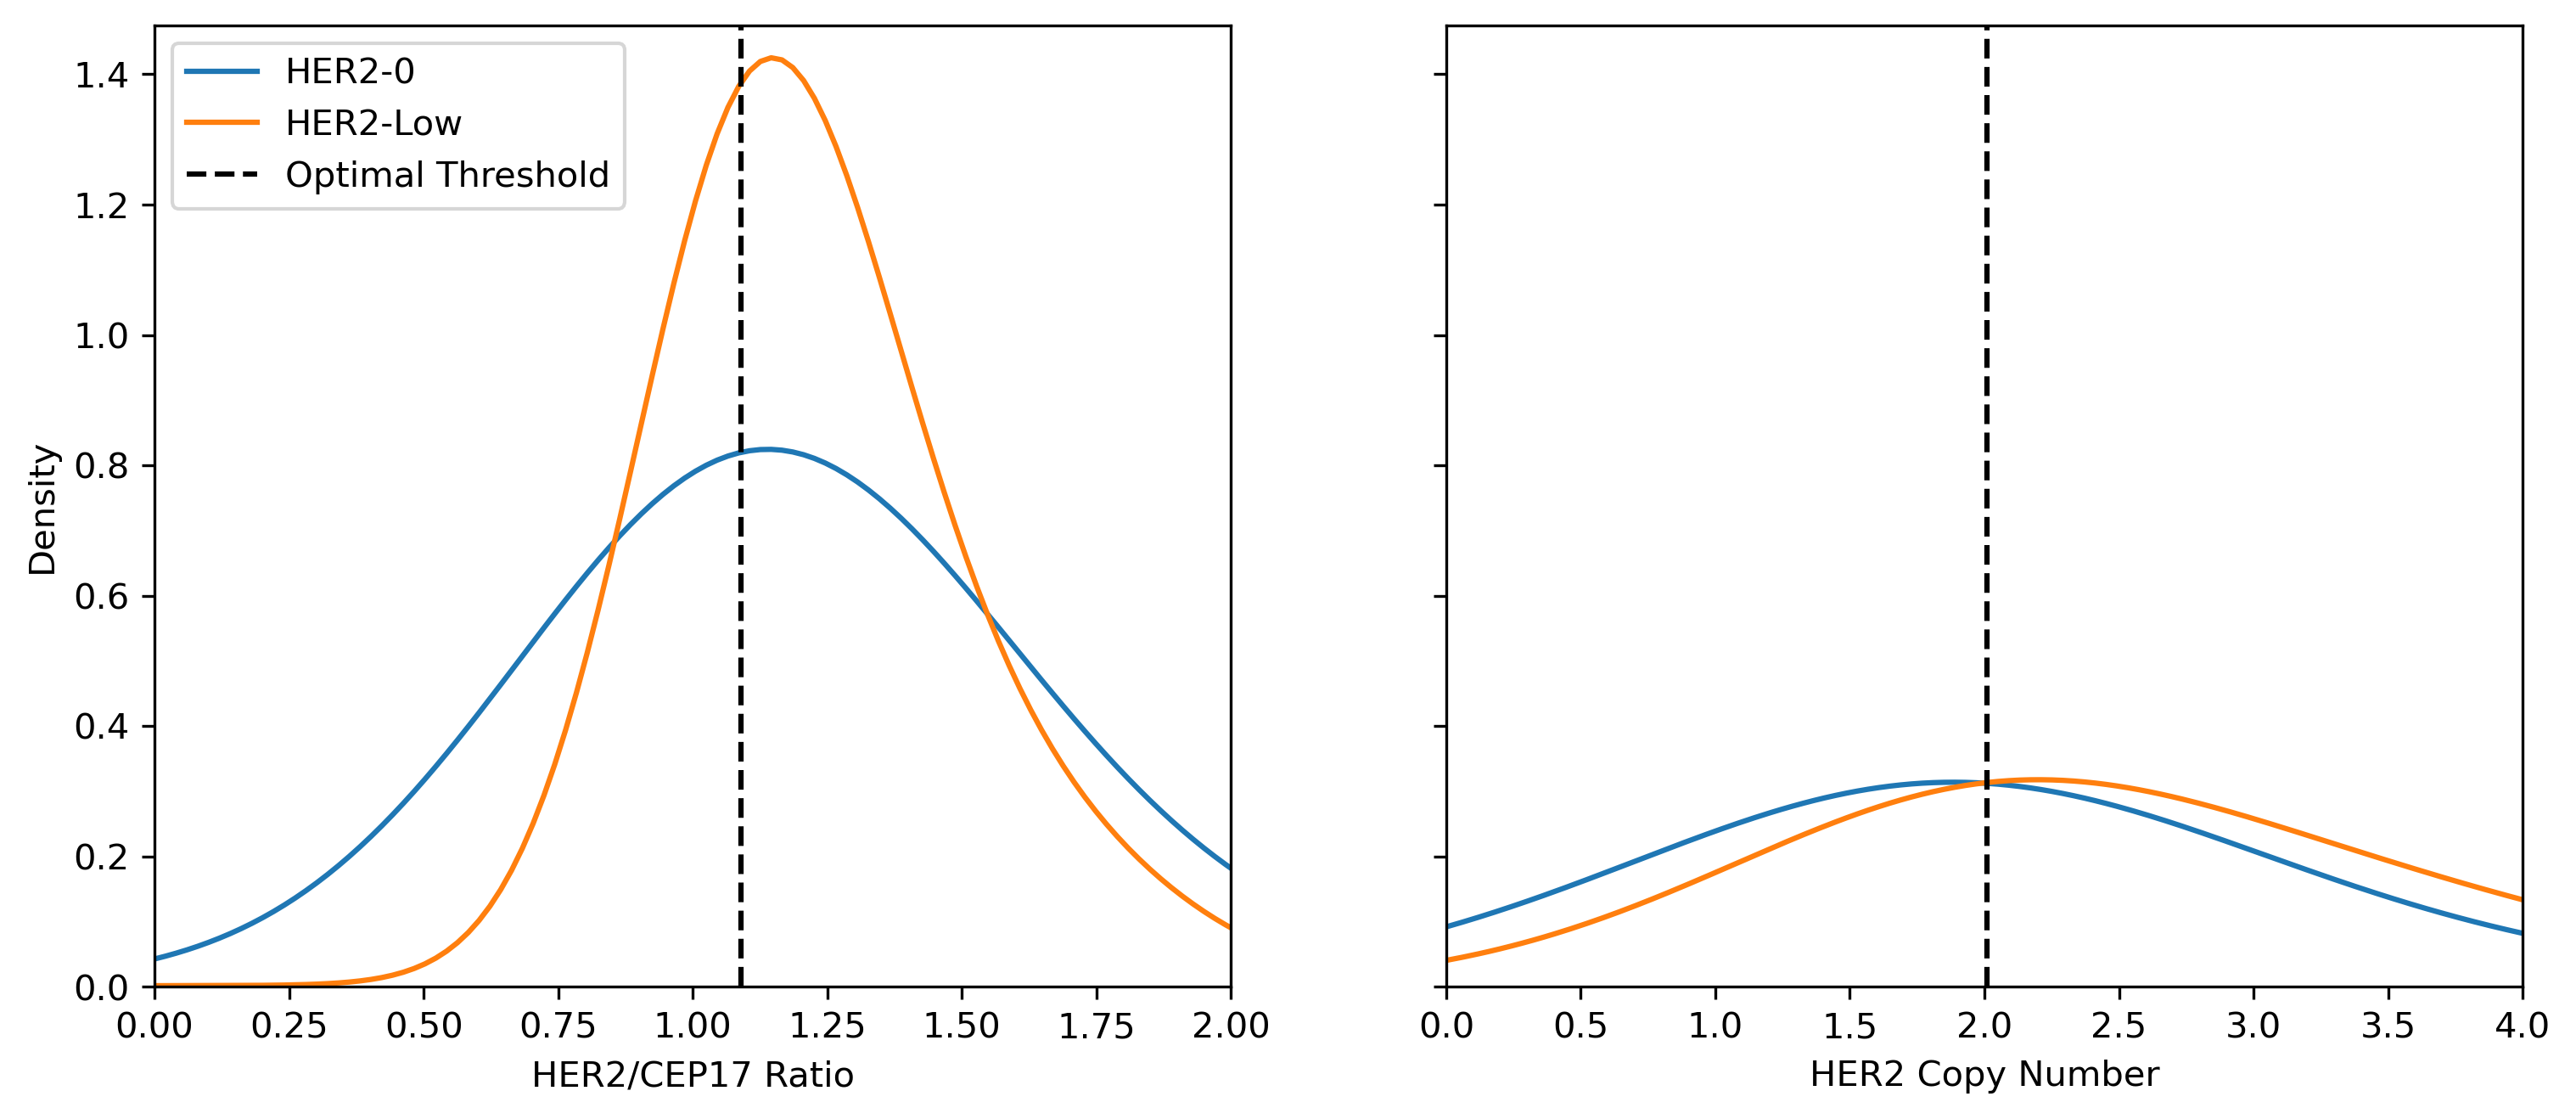

In [60]:
def sensivity_specifity_cutoff(y_true, y_score, thresh = None):
    '''Find data-driven cut-off for classification
    
    Cut-off is determied using Youden's index defined as sensitivity + specificity - 1.
    
    Parameters
    ----------
    
    y_true : array, shape = [n_samples]
        True binary labels.
        
    y_score : array, shape = [n_samples]
        Target scores, can either be probability estimates of the positive class,
        confidence values, or non-thresholded measure of decisions (as returned by
        “decision_function” on some classifiers).
        
    References
    ----------
    
    Ewald, B. (2006). Post hoc choice of cut points introduced bias to diagnostic research.
    Journal of clinical epidemiology, 59(8), 798-801.
    
    Steyerberg, E.W., Van Calster, B., & Pencina, M.J. (2011). Performance measures for
    prediction models and markers: evaluation of predictions and classifications.
    Revista Espanola de Cardiologia (English Edition), 64(9), 788-794.
    
    Jiménez-Valverde, A., & Lobo, J.M. (2007). Threshold criteria for conversion of probability
    of species presence to either–or presence–absence. Acta oecologica, 31(3), 361-369.
    '''
    from sklearn.metrics import roc_curve
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    if thresh:
        for i, t in enumerate(thresholds):
            if t <= thresh:
                return tpr[i], 1- fpr[i]
    else:
        idx = np.argmax(tpr - fpr)
        print("Optimal Cutoff: " + str(thresholds[idx]) + ", Sensitivity: " + str(tpr[idx]) + ", Specificity " + str(1-fpr[idx]))
        return thresholds[idx]

def plotHistograms(df, var, ax):
    df = df.dropna(subset = ['her2', var])
    df0 = df[df.her2 == 0]
    dflow = df[df.her2 > 0]
    ax.hist(df0[var], bins = 1000, density = True, alpha = 0.5)
    ax.hist(dflow[var], bins = 1000, density = True, alpha = 0.5)
   # ax.set_xlim([0, 10])
    
def plotGaussianDensity(df, var, ax):
    from scipy.stats import gaussian_kde
    df = df.dropna(subset = ['her2', var]).copy()
    df['her2low'] = 0
    df.loc[df.her2 > 0, 'her2low'] = 1
    df0 = df[df.her2 == 0].copy()
    dflow = df[df.her2 > 0].copy()

    xs = np.linspace(0, 4, 200)
    density0 = gaussian_kde(df0[var])
    density0.covariance_factor = lambda : .2
    density0._compute_covariance()
    ax.plot(xs,density0(xs), label = 'HER2-0')
    densitylow = gaussian_kde(dflow[var])
    densitylow.covariance_factor = lambda : .2
    densitylow._compute_covariance()
    ax.plot(xs,densitylow(xs), label = 'HER2-Low')
    
    t = sensivity_specifity_cutoff(df['her2low'], df[var])
    ax.plot([t,t], [0,3], color = 'k', linestyle = 'dashed', label = 'Optimal Threshold')
    if var == 'her2ratio':
        ax.set_ylim([0, max(densitylow(xs)) + 0.05])
        ax.legend()
        ax.set_xlim([0,2])
    else:
        ax.set_xlim([0,4])

def printSenSpecCutoffs(df):
    dfc = df.dropna(subset = ['her2', 'her2copies']).copy()
    dfr = df.dropna(subset = ['her2', 'her2ratio']).copy()
    dfc['her2low'] = 0
    dfc.loc[dfc.her2 > 0, 'her2low'] = 1
    dfr['her2low'] = 0
    dfr.loc[dfr.her2 > 0, 'her2low'] = 1
    print("Cutoff,Sensitivity Copy Number,Specificity Copy Number,Cutoff, Sensitivity Ratio,Specificity Ratio")
    for i in np.arange(1.0, 2.05, 0.05):
        sen_c, spec_c = sensivity_specifity_cutoff(dfc['her2low'], dfc['her2copies'], 3*i - 2)
        sen_r, spec_r = sensivity_specifity_cutoff(dfr['her2low'], dfr['her2ratio'], i)
        print(str(round(3*i - 2,2)) + "," + str(round(sen_c*100,1)) + "," + str(round(spec_c*100,1)) + "," + str(round(i,2)) + "," + str(round(sen_r*100,1)) + "," + str(round(spec_r*100,1)))
              
              
fig, axs = plt.subplots(1, 2, figsize = (12, 5), dpi = 300, sharey = True)
axs[0].set_ylabel("Density")
axs[0].set_xlabel("HER2/CEP17 Ratio")
axs[1].set_xlabel("HER2 Copy Number")

              

printSenSpecCutoffs(df)
print("HER2/CEP17 Ratio -")
plotGaussianDensity(df.copy(), 'her2ratio', axs[0])
print("HER2 Copy Number -")
plotGaussianDensity(df.copy(), 'her2copies', axs[1])
plt.savefig("Figure 2.png")
plt.show()
